# Detecting Deception in Enron Emails
## 3. Modeling

In this notebook, we attempt three methods of clustering and topic modeling, beginning with simple N-gram features, then reducing dimensionality for K-means using paragraph vectoring, or Doc2Vec. We also try variants of Latent Dirichlet Allocation (LDA) to identify sub-topics within emails for comparison to our keyword-targeted labels.

### 3.0 Libraries and Preprocessed Data

In [1]:
from __future__ import print_function
from __future__ import division

import os, sys
import collections
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import email
import nltk
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from scipy import sparse, hstack
from sklearn.feature_extraction.text import *
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
# run 'easy_install -U gensim' to install gensim and then re-launch jupyter notebook
#import gensim


# Helper libraries
import constants
import utils
import vocabulary

#### Load Preprocessed Dataset

In [2]:
# test import; runtime ~ 5 minutes for full set
path = '/home/cmiller11/NLP_Enron'
emails_df = pd.read_pickle(path + '/cleaned_emails.pkl')
print(emails_df.shape)
emails_df.head()

# ENTER number of rows for training; NONE if using all
num_rows = 50000

if num_rows != None:
    mini_df = emails_df.loc[range(0,num_rows),]

(517401, 3)


### LDA Topic Assignment

In [3]:
#Implement LDA for topics of each document
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

#hyperparameters
random.seed(24)
#n_samples = 2000
n_features = 3000
n_components = 10
n_top_words = 20
rand_num = 10000

rand_ids = random.sample(range(emails_df.shape[0]), rand_num)
email_samples = emails_df.loc[rand_ids,]
#training_emails = all_emails.loc[all_ids,]

train_content = list(email_samples['email_str'])
#dev_content = list(email_samples['content_str'])

#tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
#                                   max_features=n_features,
#                                   stop_words='english')

#tfidf = tfidf_vectorizer.fit_transform(all_content)

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.4, min_df=10,
                                max_features=n_features,
                                stop_words='english',
                                ngram_range = (1,1))
#t0 = time()
#tf = tf_vectorizer.fit_transform(data_samples)
#print("done in %0.3fs." % (time() - t0))
#print()

tf_train = tf_vectorizer.fit_transform(train_content)
tf_vocab = tf_vectorizer.vocabulary_
tf_feature_names = tf_vectorizer.get_feature_names()
print(tf_train.shape)

Extracting tf features for LDA...
(10000, 3000)


In [5]:
import lda
import guidedlda
import math

t0 = time()
random.seed(24)
pct_keyword_docs = 0.35
sample_keyword_doc_idx = set()
all_keyword_doc_idx = set()
phrases = ["raptor","ljm","fraud","manipulation", "condor","trutta","swap",\
               "differential","ferc", "merlin", "whitewing", "jedi", "vehicle"]
for phrase in phrases:
    query = emails_df[emails_df['email_str'].str.contains(phrase, case=False)]
    matching_indices = query.index.tolist()
    all_keyword_doc_idx = all_keyword_doc_idx.union(set(matching_indices))
    if len(matching_indices) == 0:
        print(phrase + " did not yield any results")
        continue
    num_keyword_docs = math.ceil(len(matching_indices)*pct_keyword_docs)
    rand_ids = random.sample(matching_indices, num_keyword_docs)
    sample_keyword_doc_idx = sample_keyword_doc_idx.union(set(rand_ids))
    print("after {} there are {} indices".format(phrase,len(sample_keyword_doc_idx)))     

guided_emails = emails_df.loc[list(sample_keyword_doc_idx)]

#hyperparameters
random.seed(24)
n_features = None
n_components = 10
n_top_words = 20
rand_num = 10000
seed_confidence = 0.99
max_iters = 1000

all_idx = set()
for i in emails_df.index:
    all_idx.add(i)
available_emails_idx = all_idx.difference(all_keyword_doc_idx)
print("there are {} emails non relevant emails to sample from after removing {} relevant emails"\
.format(len(available_emails_idx),len(all_keyword_doc_idx)))
rand_ids = random.sample(list(available_emails_idx), rand_num)
train_idx = list(sample_keyword_doc_idx.union(set(rand_ids)))     
email_samples = emails_df.loc[train_idx,]

print("There are {} irrelevant docs".format(rand_num))
print("the train email df will be {}".format(email_samples.shape[0]))

train_content = list(email_samples['email_str'])

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.40, min_df=10,
                                max_features=n_features,
                                stop_words='english',
                                ngram_range = (1,1))

tf_train = tf_vectorizer.fit_transform(train_content)
tf_vocab = tf_vectorizer.vocabulary_
tf_feature_names = tf_vectorizer.get_feature_names()
print("Output of CountVectorizer: ",tf_train.shape)
             


after raptor there are 229 indices
after ljm there are 544 indices
after fraud there are 892 indices
after manipulation there are 1326 indices
after condor there are 1356 indices
after trutta there are 1368 indices
after swap there are 4900 indices
after differential there are 5187 indices
after ferc there are 10836 indices
after merlin there are 10935 indices
after whitewing there are 10979 indices
after jedi there are 11094 indices
after vehicle there are 12206 indices
there are 484399 emails non relevant emails to sample from after removing 33002 relevant emails
There are 10000 irrelevant docs
the train email df will be 22206
Extracting tf features for LDA...
Output of CountVectorizer:  (22206, 22830)


In [ ]:
seed_topic_list = [phrases]
seed_topics = {}
for t_id, keywords in enumerate(seed_topic_list):
    for word in keywords:
        seed_topics[tf_feature_names.index(word)] = t_id
    
glda = guidedlda.GuidedLDA(n_topics = n_components, n_iter = max_iters, random_state = 7, refresh = 50)
glda.fit(tf_train, seed_topics = seed_topics, seed_confidence = seed_confidence)
topic_word = glda.topic_word_
print(topic_word.shape)

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(tf_feature_names)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
print("finished glda in {}".format(time() - t0))

In [24]:
t0 = time()

seed_topic_list = [phrases]
seed_topics = {}
for t_id, keywords in enumerate(seed_topic_list):
    for word in keywords:
        seed_topics[tf_feature_names.index(word)] = t_id

n_iters = 500
model_score = {}
search_params = {'n_topics':[10,12,15,20], 'alpha':[0.01,0.005,0.001,0.0001], 'eta':[0.1,0.2,0.4,0.6]}
for i in search_params['n_topics']:
    for j in search_params['alpha']:
        for k in search_params['eta']:
            glda = guidedlda.GuidedLDA(n_topics = i, n_iter = n_iters, random_state = 7, refresh = 25,\
                                       alpha = j, eta = k)
            model_score[(i,j,k)] = glda.fit(tf_train, seed_topics = seed_topics, seed_confidence = seed_confidence).loglikelihoods_[1:]
            print("finished model {},{},{} in {}".format(i,j,k, time()-t0))

INFO:guidedlda:n_documents: 22206
INFO:guidedlda:vocab_size: 22830
INFO:guidedlda:n_words: 5675974
INFO:guidedlda:n_topics: 10
INFO:guidedlda:n_iter: 500
/home/cmiller11/anaconda3/lib/python3.6/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:guidedlda:<0> log likelihood: -61762014
INFO:guidedlda:<25> log likelihood: -47006430
INFO:guidedlda:<50> log likelihood: -46544144
INFO:guidedlda:<75> log likelihood: -46375259
INFO:guidedlda:<100> log likelihood: -46320057
INFO:guidedlda:<125> log likelihood: -46299092
INFO:guidedlda:<150> log likelihood: -46293729
INFO:guidedlda:<175> log likelihood: -46297203
INFO:guidedlda:<200> log likelihood: -46302214
INFO:guidedlda:<225> log likelihood: -46297818
INFO:guidedlda:<250> log likelihood: -46282926
INFO:guidedlda:<275> lo

finished model 10,0.01,0.1 in 215.30000972747803


INFO:guidedlda:<0> log likelihood: -61686494
INFO:guidedlda:<25> log likelihood: -47192120
INFO:guidedlda:<50> log likelihood: -46729779
INFO:guidedlda:<75> log likelihood: -46520044
INFO:guidedlda:<100> log likelihood: -46437139
INFO:guidedlda:<125> log likelihood: -46409073
INFO:guidedlda:<150> log likelihood: -46399468
INFO:guidedlda:<175> log likelihood: -46373179
INFO:guidedlda:<200> log likelihood: -46349753
INFO:guidedlda:<225> log likelihood: -46341812
INFO:guidedlda:<250> log likelihood: -46342144
INFO:guidedlda:<275> log likelihood: -46339870
INFO:guidedlda:<300> log likelihood: -46344652
INFO:guidedlda:<325> log likelihood: -46338491
INFO:guidedlda:<350> log likelihood: -46334954
INFO:guidedlda:<375> log likelihood: -46334114
INFO:guidedlda:<400> log likelihood: -46330483
INFO:guidedlda:<425> log likelihood: -46329179
INFO:guidedlda:<450> log likelihood: -46328948
INFO:guidedlda:<475> log likelihood: -46329456
INFO:guidedlda:<499> log likelihood: -46334161
INFO:guidedlda:n_d

finished model 10,0.01,0.2 in 437.08926463127136


INFO:guidedlda:<0> log likelihood: -61657099
INFO:guidedlda:<25> log likelihood: -47230013
INFO:guidedlda:<50> log likelihood: -46781842
INFO:guidedlda:<75> log likelihood: -46634802
INFO:guidedlda:<100> log likelihood: -46516955
INFO:guidedlda:<125> log likelihood: -46440049
INFO:guidedlda:<150> log likelihood: -46406337
INFO:guidedlda:<175> log likelihood: -46392209
INFO:guidedlda:<200> log likelihood: -46389022
INFO:guidedlda:<225> log likelihood: -46384106
INFO:guidedlda:<250> log likelihood: -46383227
INFO:guidedlda:<275> log likelihood: -46390397
INFO:guidedlda:<300> log likelihood: -46393010
INFO:guidedlda:<325> log likelihood: -46394091
INFO:guidedlda:<350> log likelihood: -46381786
INFO:guidedlda:<375> log likelihood: -46379164
INFO:guidedlda:<400> log likelihood: -46382108
INFO:guidedlda:<425> log likelihood: -46378206
INFO:guidedlda:<450> log likelihood: -46378799
INFO:guidedlda:<475> log likelihood: -46383909
INFO:guidedlda:<499> log likelihood: -46385916
INFO:guidedlda:n_d

finished model 10,0.01,0.4 in 651.62633061409


INFO:guidedlda:<0> log likelihood: -61671456
INFO:guidedlda:<25> log likelihood: -47286985
INFO:guidedlda:<50> log likelihood: -46934084
INFO:guidedlda:<75> log likelihood: -46820177
INFO:guidedlda:<100> log likelihood: -46775035
INFO:guidedlda:<125> log likelihood: -46743867
INFO:guidedlda:<150> log likelihood: -46738298
INFO:guidedlda:<175> log likelihood: -46727248
INFO:guidedlda:<200> log likelihood: -46700157
INFO:guidedlda:<225> log likelihood: -46667649
INFO:guidedlda:<250> log likelihood: -46636465
INFO:guidedlda:<275> log likelihood: -46617618
INFO:guidedlda:<300> log likelihood: -46613484
INFO:guidedlda:<325> log likelihood: -46585286
INFO:guidedlda:<350> log likelihood: -46549051
INFO:guidedlda:<375> log likelihood: -46535020
INFO:guidedlda:<400> log likelihood: -46524274
INFO:guidedlda:<425> log likelihood: -46513269
INFO:guidedlda:<450> log likelihood: -46505780
INFO:guidedlda:<475> log likelihood: -46493449
INFO:guidedlda:<499> log likelihood: -46472564
INFO:guidedlda:n_d

finished model 10,0.01,0.6 in 877.7681930065155


INFO:guidedlda:<0> log likelihood: -61893342
INFO:guidedlda:<25> log likelihood: -47027634
INFO:guidedlda:<50> log likelihood: -46532664
INFO:guidedlda:<75> log likelihood: -46386199
INFO:guidedlda:<100> log likelihood: -46312859
INFO:guidedlda:<125> log likelihood: -46276869
INFO:guidedlda:<150> log likelihood: -46259500
INFO:guidedlda:<175> log likelihood: -46237658
INFO:guidedlda:<200> log likelihood: -46227697
INFO:guidedlda:<225> log likelihood: -46225422
INFO:guidedlda:<250> log likelihood: -46229252
INFO:guidedlda:<275> log likelihood: -46209975
INFO:guidedlda:<300> log likelihood: -46206847
INFO:guidedlda:<325> log likelihood: -46206610
INFO:guidedlda:<350> log likelihood: -46205228
INFO:guidedlda:<375> log likelihood: -46207740
INFO:guidedlda:<400> log likelihood: -46195747
INFO:guidedlda:<425> log likelihood: -46186598
INFO:guidedlda:<450> log likelihood: -46189039
INFO:guidedlda:<475> log likelihood: -46190753
INFO:guidedlda:<499> log likelihood: -46192211
INFO:guidedlda:n_d

finished model 10,0.005,0.1 in 1104.4344477653503


INFO:guidedlda:<0> log likelihood: -61817822
INFO:guidedlda:<25> log likelihood: -47152910
INFO:guidedlda:<50> log likelihood: -46695279
INFO:guidedlda:<75> log likelihood: -46550299
INFO:guidedlda:<100> log likelihood: -46475394
INFO:guidedlda:<125> log likelihood: -46444546
INFO:guidedlda:<150> log likelihood: -46413318
INFO:guidedlda:<175> log likelihood: -46398403
INFO:guidedlda:<200> log likelihood: -46382151
INFO:guidedlda:<225> log likelihood: -46369651
INFO:guidedlda:<250> log likelihood: -46358145
INFO:guidedlda:<275> log likelihood: -46348389
INFO:guidedlda:<300> log likelihood: -46332445
INFO:guidedlda:<325> log likelihood: -46318215
INFO:guidedlda:<350> log likelihood: -46311998
INFO:guidedlda:<375> log likelihood: -46311492
INFO:guidedlda:<400> log likelihood: -46307666
INFO:guidedlda:<425> log likelihood: -46310661
INFO:guidedlda:<450> log likelihood: -46308406
INFO:guidedlda:<475> log likelihood: -46306620
INFO:guidedlda:<499> log likelihood: -46305019
INFO:guidedlda:n_d

finished model 10,0.005,0.2 in 1337.18279504776


INFO:guidedlda:<0> log likelihood: -61788427
INFO:guidedlda:<25> log likelihood: -47259803
INFO:guidedlda:<50> log likelihood: -46801366
INFO:guidedlda:<75> log likelihood: -46682829
INFO:guidedlda:<100> log likelihood: -46623203
INFO:guidedlda:<125> log likelihood: -46582388
INFO:guidedlda:<150> log likelihood: -46532199
INFO:guidedlda:<175> log likelihood: -46474947
INFO:guidedlda:<200> log likelihood: -46431209
INFO:guidedlda:<225> log likelihood: -46400519
INFO:guidedlda:<250> log likelihood: -46375600
INFO:guidedlda:<275> log likelihood: -46364337
INFO:guidedlda:<300> log likelihood: -46335873
INFO:guidedlda:<325> log likelihood: -46321378
INFO:guidedlda:<350> log likelihood: -46314129
INFO:guidedlda:<375> log likelihood: -46303869
INFO:guidedlda:<400> log likelihood: -46300081
INFO:guidedlda:<425> log likelihood: -46293968
INFO:guidedlda:<450> log likelihood: -46290128
INFO:guidedlda:<475> log likelihood: -46286073
INFO:guidedlda:<499> log likelihood: -46282418
INFO:guidedlda:n_d

finished model 10,0.005,0.4 in 1565.0814185142517


INFO:guidedlda:<0> log likelihood: -61802784
INFO:guidedlda:<25> log likelihood: -47275254
INFO:guidedlda:<50> log likelihood: -46900632
INFO:guidedlda:<75> log likelihood: -46809372
INFO:guidedlda:<100> log likelihood: -46764711
INFO:guidedlda:<125> log likelihood: -46704116
INFO:guidedlda:<150> log likelihood: -46659367
INFO:guidedlda:<175> log likelihood: -46629915
INFO:guidedlda:<200> log likelihood: -46617239
INFO:guidedlda:<225> log likelihood: -46606665
INFO:guidedlda:<250> log likelihood: -46602024
INFO:guidedlda:<275> log likelihood: -46604019
INFO:guidedlda:<300> log likelihood: -46610873
INFO:guidedlda:<325> log likelihood: -46605221
INFO:guidedlda:<350> log likelihood: -46612094
INFO:guidedlda:<375> log likelihood: -46598759
INFO:guidedlda:<400> log likelihood: -46589058
INFO:guidedlda:<425> log likelihood: -46582985
INFO:guidedlda:<450> log likelihood: -46572359
INFO:guidedlda:<475> log likelihood: -46550246
INFO:guidedlda:<499> log likelihood: -46525137
INFO:guidedlda:n_d

finished model 10,0.005,0.6 in 1790.875921010971


INFO:guidedlda:<0> log likelihood: -62202021
INFO:guidedlda:<25> log likelihood: -47106968
INFO:guidedlda:<50> log likelihood: -46597839
INFO:guidedlda:<75> log likelihood: -46470898
INFO:guidedlda:<100> log likelihood: -46399298
INFO:guidedlda:<125> log likelihood: -46348128
INFO:guidedlda:<150> log likelihood: -46307206
INFO:guidedlda:<175> log likelihood: -46280343
INFO:guidedlda:<200> log likelihood: -46250614
INFO:guidedlda:<225> log likelihood: -46233271
INFO:guidedlda:<250> log likelihood: -46218649
INFO:guidedlda:<275> log likelihood: -46195102
INFO:guidedlda:<300> log likelihood: -46180509
INFO:guidedlda:<325> log likelihood: -46159378
INFO:guidedlda:<350> log likelihood: -46147699
INFO:guidedlda:<375> log likelihood: -46139227
INFO:guidedlda:<400> log likelihood: -46126905
INFO:guidedlda:<425> log likelihood: -46123072
INFO:guidedlda:<450> log likelihood: -46117528
INFO:guidedlda:<475> log likelihood: -46115583
INFO:guidedlda:<499> log likelihood: -46112157
INFO:guidedlda:n_d

finished model 10,0.001,0.1 in 2018.699916601181


INFO:guidedlda:<0> log likelihood: -62126501
INFO:guidedlda:<25> log likelihood: -47249110
INFO:guidedlda:<50> log likelihood: -46764191
INFO:guidedlda:<75> log likelihood: -46619197
INFO:guidedlda:<100> log likelihood: -46518600
INFO:guidedlda:<125> log likelihood: -46452127
INFO:guidedlda:<150> log likelihood: -46413911
INFO:guidedlda:<175> log likelihood: -46392287
INFO:guidedlda:<200> log likelihood: -46358274
INFO:guidedlda:<225> log likelihood: -46336177
INFO:guidedlda:<250> log likelihood: -46314394
INFO:guidedlda:<275> log likelihood: -46301979
INFO:guidedlda:<300> log likelihood: -46286345
INFO:guidedlda:<325> log likelihood: -46273160
INFO:guidedlda:<350> log likelihood: -46264571
INFO:guidedlda:<375> log likelihood: -46254872
INFO:guidedlda:<400> log likelihood: -46249851
INFO:guidedlda:<425> log likelihood: -46244443
INFO:guidedlda:<450> log likelihood: -46241628
INFO:guidedlda:<475> log likelihood: -46239800
INFO:guidedlda:<499> log likelihood: -46235649
INFO:guidedlda:n_d

finished model 10,0.001,0.2 in 2242.894936323166


INFO:guidedlda:<0> log likelihood: -62097106
INFO:guidedlda:<25> log likelihood: -47292610
INFO:guidedlda:<50> log likelihood: -46825436
INFO:guidedlda:<75> log likelihood: -46695458
INFO:guidedlda:<100> log likelihood: -46607897
INFO:guidedlda:<125> log likelihood: -46539159
INFO:guidedlda:<150> log likelihood: -46505242
INFO:guidedlda:<175> log likelihood: -46465332
INFO:guidedlda:<200> log likelihood: -46443366
INFO:guidedlda:<225> log likelihood: -46425164
INFO:guidedlda:<250> log likelihood: -46405055
INFO:guidedlda:<275> log likelihood: -46397420
INFO:guidedlda:<300> log likelihood: -46382174
INFO:guidedlda:<325> log likelihood: -46373438
INFO:guidedlda:<350> log likelihood: -46358812
INFO:guidedlda:<375> log likelihood: -46341611
INFO:guidedlda:<400> log likelihood: -46328006
INFO:guidedlda:<425> log likelihood: -46322362
INFO:guidedlda:<450> log likelihood: -46320124
INFO:guidedlda:<475> log likelihood: -46313389
INFO:guidedlda:<499> log likelihood: -46307551
INFO:guidedlda:n_d

finished model 10,0.001,0.4 in 2471.7463965415955


INFO:guidedlda:<0> log likelihood: -62111463
INFO:guidedlda:<25> log likelihood: -47281926
INFO:guidedlda:<50> log likelihood: -46905005
INFO:guidedlda:<75> log likelihood: -46796273
INFO:guidedlda:<100> log likelihood: -46744839
INFO:guidedlda:<125> log likelihood: -46706345
INFO:guidedlda:<150> log likelihood: -46673609
INFO:guidedlda:<175> log likelihood: -46654420
INFO:guidedlda:<200> log likelihood: -46632428
INFO:guidedlda:<225> log likelihood: -46619407
INFO:guidedlda:<250> log likelihood: -46604999
INFO:guidedlda:<275> log likelihood: -46591794
INFO:guidedlda:<300> log likelihood: -46584601
INFO:guidedlda:<325> log likelihood: -46568981
INFO:guidedlda:<350> log likelihood: -46558711
INFO:guidedlda:<375> log likelihood: -46549032
INFO:guidedlda:<400> log likelihood: -46546166
INFO:guidedlda:<425> log likelihood: -46540840
INFO:guidedlda:<450> log likelihood: -46535995
INFO:guidedlda:<475> log likelihood: -46529393
INFO:guidedlda:<499> log likelihood: -46524407
INFO:guidedlda:n_d

finished model 10,0.001,0.6 in 2694.383688688278


INFO:guidedlda:<0> log likelihood: -62646106
INFO:guidedlda:<25> log likelihood: -47189764
INFO:guidedlda:<50> log likelihood: -46685111
INFO:guidedlda:<75> log likelihood: -46567676
INFO:guidedlda:<100> log likelihood: -46500086
INFO:guidedlda:<125> log likelihood: -46449657
INFO:guidedlda:<150> log likelihood: -46395742
INFO:guidedlda:<175> log likelihood: -46363338
INFO:guidedlda:<200> log likelihood: -46340040
INFO:guidedlda:<225> log likelihood: -46324469
INFO:guidedlda:<250> log likelihood: -46310955
INFO:guidedlda:<275> log likelihood: -46297943
INFO:guidedlda:<300> log likelihood: -46286048
INFO:guidedlda:<325> log likelihood: -46275477
INFO:guidedlda:<350> log likelihood: -46263359
INFO:guidedlda:<375> log likelihood: -46258612
INFO:guidedlda:<400> log likelihood: -46248158
INFO:guidedlda:<425> log likelihood: -46245446
INFO:guidedlda:<450> log likelihood: -46237260
INFO:guidedlda:<475> log likelihood: -46233258
INFO:guidedlda:<499> log likelihood: -46223905
INFO:guidedlda:n_d

finished model 10,0.0001,0.1 in 2921.844214439392


INFO:guidedlda:<0> log likelihood: -62570586
INFO:guidedlda:<25> log likelihood: -47335558
INFO:guidedlda:<50> log likelihood: -46823161
INFO:guidedlda:<75> log likelihood: -46657801
INFO:guidedlda:<100> log likelihood: -46575168
INFO:guidedlda:<125> log likelihood: -46536823
INFO:guidedlda:<150> log likelihood: -46502227
INFO:guidedlda:<175> log likelihood: -46483615
INFO:guidedlda:<200> log likelihood: -46466160
INFO:guidedlda:<225> log likelihood: -46446296
INFO:guidedlda:<250> log likelihood: -46434978
INFO:guidedlda:<275> log likelihood: -46421118
INFO:guidedlda:<300> log likelihood: -46408325
INFO:guidedlda:<325> log likelihood: -46401409
INFO:guidedlda:<350> log likelihood: -46383863
INFO:guidedlda:<375> log likelihood: -46379296
INFO:guidedlda:<400> log likelihood: -46373487
INFO:guidedlda:<425> log likelihood: -46365056
INFO:guidedlda:<450> log likelihood: -46356652
INFO:guidedlda:<475> log likelihood: -46353232
INFO:guidedlda:<499> log likelihood: -46348453
INFO:guidedlda:n_d

finished model 10,0.0001,0.2 in 3151.5667231082916


INFO:guidedlda:<0> log likelihood: -62541191
INFO:guidedlda:<25> log likelihood: -47363548
INFO:guidedlda:<50> log likelihood: -46882908
INFO:guidedlda:<75> log likelihood: -46716011
INFO:guidedlda:<100> log likelihood: -46632333
INFO:guidedlda:<125> log likelihood: -46583475
INFO:guidedlda:<150> log likelihood: -46553394
INFO:guidedlda:<175> log likelihood: -46521175
INFO:guidedlda:<200> log likelihood: -46499841
INFO:guidedlda:<225> log likelihood: -46482786
INFO:guidedlda:<250> log likelihood: -46473479
INFO:guidedlda:<275> log likelihood: -46461658
INFO:guidedlda:<300> log likelihood: -46453318
INFO:guidedlda:<325> log likelihood: -46448134
INFO:guidedlda:<350> log likelihood: -46434436
INFO:guidedlda:<375> log likelihood: -46426275
INFO:guidedlda:<400> log likelihood: -46424307
INFO:guidedlda:<425> log likelihood: -46416678
INFO:guidedlda:<450> log likelihood: -46413575
INFO:guidedlda:<475> log likelihood: -46407544
INFO:guidedlda:<499> log likelihood: -46400825
INFO:guidedlda:n_d

finished model 10,0.0001,0.4 in 3381.5391941070557


INFO:guidedlda:<0> log likelihood: -62555548
INFO:guidedlda:<25> log likelihood: -47389347
INFO:guidedlda:<50> log likelihood: -46938233
INFO:guidedlda:<75> log likelihood: -46815734
INFO:guidedlda:<100> log likelihood: -46748693
INFO:guidedlda:<125> log likelihood: -46702277
INFO:guidedlda:<150> log likelihood: -46674696
INFO:guidedlda:<175> log likelihood: -46655968
INFO:guidedlda:<200> log likelihood: -46636313
INFO:guidedlda:<225> log likelihood: -46622944
INFO:guidedlda:<250> log likelihood: -46612281
INFO:guidedlda:<275> log likelihood: -46599402
INFO:guidedlda:<300> log likelihood: -46589452
INFO:guidedlda:<325> log likelihood: -46577604
INFO:guidedlda:<350> log likelihood: -46565586
INFO:guidedlda:<375> log likelihood: -46558121
INFO:guidedlda:<400> log likelihood: -46553434
INFO:guidedlda:<425> log likelihood: -46541743
INFO:guidedlda:<450> log likelihood: -46538833
INFO:guidedlda:<475> log likelihood: -46532197
INFO:guidedlda:<499> log likelihood: -46522532
INFO:guidedlda:n_d

finished model 10,0.0001,0.6 in 3604.906614780426


INFO:guidedlda:<0> log likelihood: -63038640
INFO:guidedlda:<25> log likelihood: -47223463
INFO:guidedlda:<50> log likelihood: -46504400
INFO:guidedlda:<75> log likelihood: -46318073
INFO:guidedlda:<100> log likelihood: -46233357
INFO:guidedlda:<125> log likelihood: -46184141
INFO:guidedlda:<150> log likelihood: -46135573
INFO:guidedlda:<175> log likelihood: -46087496
INFO:guidedlda:<200> log likelihood: -46055351
INFO:guidedlda:<225> log likelihood: -46042508
INFO:guidedlda:<250> log likelihood: -46036818
INFO:guidedlda:<275> log likelihood: -46012615
INFO:guidedlda:<300> log likelihood: -46021114
INFO:guidedlda:<325> log likelihood: -46024844
INFO:guidedlda:<350> log likelihood: -46027127
INFO:guidedlda:<375> log likelihood: -46026354
INFO:guidedlda:<400> log likelihood: -46024582
INFO:guidedlda:<425> log likelihood: -46025842
INFO:guidedlda:<450> log likelihood: -46027449
INFO:guidedlda:<475> log likelihood: -46028212
INFO:guidedlda:<499> log likelihood: -46023985
INFO:guidedlda:n_d

finished model 12,0.01,0.1 in 3844.985277414322


INFO:guidedlda:<0> log likelihood: -62952441
INFO:guidedlda:<25> log likelihood: -47067627
INFO:guidedlda:<50> log likelihood: -46582060
INFO:guidedlda:<75> log likelihood: -46405925
INFO:guidedlda:<100> log likelihood: -46324018
INFO:guidedlda:<125> log likelihood: -46287047
INFO:guidedlda:<150> log likelihood: -46269364
INFO:guidedlda:<175> log likelihood: -46217397
INFO:guidedlda:<200> log likelihood: -46187518
INFO:guidedlda:<225> log likelihood: -46158472
INFO:guidedlda:<250> log likelihood: -46142756
INFO:guidedlda:<275> log likelihood: -46097950
INFO:guidedlda:<300> log likelihood: -46094769
INFO:guidedlda:<325> log likelihood: -46079994
INFO:guidedlda:<350> log likelihood: -46066624
INFO:guidedlda:<375> log likelihood: -46050786
INFO:guidedlda:<400> log likelihood: -46042800
INFO:guidedlda:<425> log likelihood: -46040622
INFO:guidedlda:<450> log likelihood: -46043152
INFO:guidedlda:<475> log likelihood: -46037274
INFO:guidedlda:<499> log likelihood: -46032106
INFO:guidedlda:n_d

finished model 12,0.01,0.2 in 4086.7881672382355


INFO:guidedlda:<0> log likelihood: -62921078
INFO:guidedlda:<25> log likelihood: -47252155
INFO:guidedlda:<50> log likelihood: -46711067
INFO:guidedlda:<75> log likelihood: -46429546
INFO:guidedlda:<100> log likelihood: -46221632
INFO:guidedlda:<125> log likelihood: -46129493
INFO:guidedlda:<150> log likelihood: -46097873
INFO:guidedlda:<175> log likelihood: -46096836
INFO:guidedlda:<200> log likelihood: -46099405
INFO:guidedlda:<225> log likelihood: -46100887
INFO:guidedlda:<250> log likelihood: -46104959
INFO:guidedlda:<275> log likelihood: -46104855
INFO:guidedlda:<300> log likelihood: -46108319
INFO:guidedlda:<325> log likelihood: -46105751
INFO:guidedlda:<350> log likelihood: -46110613
INFO:guidedlda:<375> log likelihood: -46115584
INFO:guidedlda:<400> log likelihood: -46114933
INFO:guidedlda:<425> log likelihood: -46126442
INFO:guidedlda:<450> log likelihood: -46124406
INFO:guidedlda:<475> log likelihood: -46133040
INFO:guidedlda:<499> log likelihood: -46126475
INFO:guidedlda:n_d

finished model 12,0.01,0.4 in 4327.226636171341


INFO:guidedlda:<0> log likelihood: -62939902
INFO:guidedlda:<25> log likelihood: -47311519
INFO:guidedlda:<50> log likelihood: -46640413
INFO:guidedlda:<75> log likelihood: -46441096
INFO:guidedlda:<100> log likelihood: -46333407
INFO:guidedlda:<125> log likelihood: -46311482
INFO:guidedlda:<150> log likelihood: -46302924
INFO:guidedlda:<175> log likelihood: -46301462
INFO:guidedlda:<200> log likelihood: -46298909
INFO:guidedlda:<225> log likelihood: -46301163
INFO:guidedlda:<250> log likelihood: -46298072
INFO:guidedlda:<275> log likelihood: -46298045
INFO:guidedlda:<300> log likelihood: -46299126
INFO:guidedlda:<325> log likelihood: -46288654
INFO:guidedlda:<350> log likelihood: -46282735
INFO:guidedlda:<375> log likelihood: -46279925
INFO:guidedlda:<400> log likelihood: -46273147
INFO:guidedlda:<425> log likelihood: -46269617
INFO:guidedlda:<450> log likelihood: -46260868
INFO:guidedlda:<475> log likelihood: -46256731
INFO:guidedlda:<499> log likelihood: -46251287
INFO:guidedlda:n_d

finished model 12,0.01,0.6 in 4564.975412607193


INFO:guidedlda:<0> log likelihood: -63197855
INFO:guidedlda:<25> log likelihood: -47269481
INFO:guidedlda:<50> log likelihood: -46643257
INFO:guidedlda:<75> log likelihood: -46440237
INFO:guidedlda:<100> log likelihood: -46219709
INFO:guidedlda:<125> log likelihood: -46140475
INFO:guidedlda:<150> log likelihood: -46102963
INFO:guidedlda:<175> log likelihood: -46073591
INFO:guidedlda:<200> log likelihood: -46047996
INFO:guidedlda:<225> log likelihood: -46013899
INFO:guidedlda:<250> log likelihood: -45973461
INFO:guidedlda:<275> log likelihood: -45958667
INFO:guidedlda:<300> log likelihood: -45956265
INFO:guidedlda:<325> log likelihood: -45948429
INFO:guidedlda:<350> log likelihood: -45945434
INFO:guidedlda:<375> log likelihood: -45948367
INFO:guidedlda:<400> log likelihood: -45936541
INFO:guidedlda:<425> log likelihood: -45937721
INFO:guidedlda:<450> log likelihood: -45940147
INFO:guidedlda:<475> log likelihood: -45948350
INFO:guidedlda:<499> log likelihood: -45942571
INFO:guidedlda:n_d

finished model 12,0.005,0.1 in 4804.236330032349


INFO:guidedlda:<0> log likelihood: -63111657
INFO:guidedlda:<25> log likelihood: -47171144
INFO:guidedlda:<50> log likelihood: -46662159
INFO:guidedlda:<75> log likelihood: -46475967
INFO:guidedlda:<100> log likelihood: -46389304
INFO:guidedlda:<125> log likelihood: -46319345
INFO:guidedlda:<150> log likelihood: -46259538
INFO:guidedlda:<175> log likelihood: -46215321
INFO:guidedlda:<200> log likelihood: -46182290
INFO:guidedlda:<225> log likelihood: -46165985
INFO:guidedlda:<250> log likelihood: -46161972
INFO:guidedlda:<275> log likelihood: -46157389
INFO:guidedlda:<300> log likelihood: -46159893
INFO:guidedlda:<325> log likelihood: -46156736
INFO:guidedlda:<350> log likelihood: -46151686
INFO:guidedlda:<375> log likelihood: -46140053
INFO:guidedlda:<400> log likelihood: -46124897
INFO:guidedlda:<425> log likelihood: -46107825
INFO:guidedlda:<450> log likelihood: -46077132
INFO:guidedlda:<475> log likelihood: -46058706
INFO:guidedlda:<499> log likelihood: -46048236
INFO:guidedlda:n_d

finished model 12,0.005,0.2 in 5043.7334904670715


INFO:guidedlda:<0> log likelihood: -63080293
INFO:guidedlda:<25> log likelihood: -47226942
INFO:guidedlda:<50> log likelihood: -46626987
INFO:guidedlda:<75> log likelihood: -46447385
INFO:guidedlda:<100> log likelihood: -46361497
INFO:guidedlda:<125> log likelihood: -46306758
INFO:guidedlda:<150> log likelihood: -46257820
INFO:guidedlda:<175> log likelihood: -46218951
INFO:guidedlda:<200> log likelihood: -46179932
INFO:guidedlda:<225> log likelihood: -46156086
INFO:guidedlda:<250> log likelihood: -46139236
INFO:guidedlda:<275> log likelihood: -46129638
INFO:guidedlda:<300> log likelihood: -46123259
INFO:guidedlda:<325> log likelihood: -46121746
INFO:guidedlda:<350> log likelihood: -46119169
INFO:guidedlda:<375> log likelihood: -46123101
INFO:guidedlda:<400> log likelihood: -46111746
INFO:guidedlda:<425> log likelihood: -46113063
INFO:guidedlda:<450> log likelihood: -46113504
INFO:guidedlda:<475> log likelihood: -46112446
INFO:guidedlda:<499> log likelihood: -46110338
INFO:guidedlda:n_d

finished model 12,0.005,0.4 in 5285.3763654232025


INFO:guidedlda:<0> log likelihood: -63099118
INFO:guidedlda:<25> log likelihood: -47346943
INFO:guidedlda:<50> log likelihood: -46802447
INFO:guidedlda:<75> log likelihood: -46635247
INFO:guidedlda:<100> log likelihood: -46533897
INFO:guidedlda:<125> log likelihood: -46450604
INFO:guidedlda:<150> log likelihood: -46413163
INFO:guidedlda:<175> log likelihood: -46387131
INFO:guidedlda:<200> log likelihood: -46376876
INFO:guidedlda:<225> log likelihood: -46367311
INFO:guidedlda:<250> log likelihood: -46357269
INFO:guidedlda:<275> log likelihood: -46351645
INFO:guidedlda:<300> log likelihood: -46342279
INFO:guidedlda:<325> log likelihood: -46333348
INFO:guidedlda:<350> log likelihood: -46337235
INFO:guidedlda:<375> log likelihood: -46335228
INFO:guidedlda:<400> log likelihood: -46327904
INFO:guidedlda:<425> log likelihood: -46325266
INFO:guidedlda:<450> log likelihood: -46306492
INFO:guidedlda:<475> log likelihood: -46308737
INFO:guidedlda:<499> log likelihood: -46301549
INFO:guidedlda:n_d

finished model 12,0.005,0.6 in 5529.693217515945


INFO:guidedlda:<0> log likelihood: -63572355
INFO:guidedlda:<25> log likelihood: -47316076
INFO:guidedlda:<50> log likelihood: -46614462
INFO:guidedlda:<75> log likelihood: -46408145
INFO:guidedlda:<100> log likelihood: -46316138
INFO:guidedlda:<125> log likelihood: -46251703
INFO:guidedlda:<150> log likelihood: -46215986
INFO:guidedlda:<175> log likelihood: -46179204
INFO:guidedlda:<200> log likelihood: -46157746
INFO:guidedlda:<225> log likelihood: -46133523
INFO:guidedlda:<250> log likelihood: -46123255
INFO:guidedlda:<275> log likelihood: -46109843
INFO:guidedlda:<300> log likelihood: -46092325
INFO:guidedlda:<325> log likelihood: -46076550
INFO:guidedlda:<350> log likelihood: -46066112
INFO:guidedlda:<375> log likelihood: -46050279
INFO:guidedlda:<400> log likelihood: -46039947
INFO:guidedlda:<425> log likelihood: -46031621
INFO:guidedlda:<450> log likelihood: -46023020
INFO:guidedlda:<475> log likelihood: -46009205
INFO:guidedlda:<499> log likelihood: -45998018
INFO:guidedlda:n_d

finished model 12,0.001,0.1 in 5769.100562095642


INFO:guidedlda:<0> log likelihood: -63486157
INFO:guidedlda:<25> log likelihood: -47211547
INFO:guidedlda:<50> log likelihood: -46708274
INFO:guidedlda:<75> log likelihood: -46536118
INFO:guidedlda:<100> log likelihood: -46452492
INFO:guidedlda:<125> log likelihood: -46397628
INFO:guidedlda:<150> log likelihood: -46358199
INFO:guidedlda:<175> log likelihood: -46319761
INFO:guidedlda:<200> log likelihood: -46293121
INFO:guidedlda:<225> log likelihood: -46251669
INFO:guidedlda:<250> log likelihood: -46232524
INFO:guidedlda:<275> log likelihood: -46214708
INFO:guidedlda:<300> log likelihood: -46197284
INFO:guidedlda:<325> log likelihood: -46180038
INFO:guidedlda:<350> log likelihood: -46166019
INFO:guidedlda:<375> log likelihood: -46159532
INFO:guidedlda:<400> log likelihood: -46147203
INFO:guidedlda:<425> log likelihood: -46134292
INFO:guidedlda:<450> log likelihood: -46114009
INFO:guidedlda:<475> log likelihood: -46106333
INFO:guidedlda:<499> log likelihood: -46102147
INFO:guidedlda:n_d

finished model 12,0.001,0.2 in 6008.139371871948


INFO:guidedlda:<0> log likelihood: -63454793
INFO:guidedlda:<25> log likelihood: -47323169
INFO:guidedlda:<50> log likelihood: -46795046
INFO:guidedlda:<75> log likelihood: -46453300
INFO:guidedlda:<100> log likelihood: -46339408
INFO:guidedlda:<125> log likelihood: -46280409
INFO:guidedlda:<150> log likelihood: -46247281
INFO:guidedlda:<175> log likelihood: -46213005
INFO:guidedlda:<200> log likelihood: -46178820
INFO:guidedlda:<225> log likelihood: -46153580
INFO:guidedlda:<250> log likelihood: -46132448
INFO:guidedlda:<275> log likelihood: -46108549
INFO:guidedlda:<300> log likelihood: -46091712
INFO:guidedlda:<325> log likelihood: -46075207
INFO:guidedlda:<350> log likelihood: -46063150
INFO:guidedlda:<375> log likelihood: -46050855
INFO:guidedlda:<400> log likelihood: -46033710
INFO:guidedlda:<425> log likelihood: -46029008
INFO:guidedlda:<450> log likelihood: -46010800
INFO:guidedlda:<475> log likelihood: -46005684
INFO:guidedlda:<499> log likelihood: -45994108
INFO:guidedlda:n_d

finished model 12,0.001,0.4 in 6247.77786898613


INFO:guidedlda:<0> log likelihood: -63473618
INFO:guidedlda:<25> log likelihood: -47361587
INFO:guidedlda:<50> log likelihood: -46809572
INFO:guidedlda:<75> log likelihood: -46665619
INFO:guidedlda:<100> log likelihood: -46590391
INFO:guidedlda:<125> log likelihood: -46533820
INFO:guidedlda:<150> log likelihood: -46492268
INFO:guidedlda:<175> log likelihood: -46462885
INFO:guidedlda:<200> log likelihood: -46435310
INFO:guidedlda:<225> log likelihood: -46404052
INFO:guidedlda:<250> log likelihood: -46383519
INFO:guidedlda:<275> log likelihood: -46361930
INFO:guidedlda:<300> log likelihood: -46343633
INFO:guidedlda:<325> log likelihood: -46332240
INFO:guidedlda:<350> log likelihood: -46322084
INFO:guidedlda:<375> log likelihood: -46317108
INFO:guidedlda:<400> log likelihood: -46300199
INFO:guidedlda:<425> log likelihood: -46291411
INFO:guidedlda:<450> log likelihood: -46281398
INFO:guidedlda:<475> log likelihood: -46273541
INFO:guidedlda:<499> log likelihood: -46265662
INFO:guidedlda:n_d

finished model 12,0.001,0.6 in 6493.183878421783


INFO:guidedlda:<0> log likelihood: -64111327
INFO:guidedlda:<25> log likelihood: -47418555
INFO:guidedlda:<50> log likelihood: -46739418
INFO:guidedlda:<75> log likelihood: -46548346
INFO:guidedlda:<100> log likelihood: -46457807
INFO:guidedlda:<125> log likelihood: -46400665
INFO:guidedlda:<150> log likelihood: -46361746
INFO:guidedlda:<175> log likelihood: -46328130
INFO:guidedlda:<200> log likelihood: -46305424
INFO:guidedlda:<225> log likelihood: -46283975
INFO:guidedlda:<250> log likelihood: -46266571
INFO:guidedlda:<275> log likelihood: -46248215
INFO:guidedlda:<300> log likelihood: -46237390
INFO:guidedlda:<325> log likelihood: -46220346
INFO:guidedlda:<350> log likelihood: -46206821
INFO:guidedlda:<375> log likelihood: -46180785
INFO:guidedlda:<400> log likelihood: -46166741
INFO:guidedlda:<425> log likelihood: -46160153
INFO:guidedlda:<450> log likelihood: -46150085
INFO:guidedlda:<475> log likelihood: -46140604
INFO:guidedlda:<499> log likelihood: -46132053
INFO:guidedlda:n_d

finished model 12,0.0001,0.1 in 6739.912109375


INFO:guidedlda:<0> log likelihood: -64025129
INFO:guidedlda:<25> log likelihood: -47339047
INFO:guidedlda:<50> log likelihood: -46769514
INFO:guidedlda:<75> log likelihood: -46581370
INFO:guidedlda:<100> log likelihood: -46484124
INFO:guidedlda:<125> log likelihood: -46432272
INFO:guidedlda:<150> log likelihood: -46394820
INFO:guidedlda:<175> log likelihood: -46365879
INFO:guidedlda:<200> log likelihood: -46349002
INFO:guidedlda:<225> log likelihood: -46322882
INFO:guidedlda:<250> log likelihood: -46306491
INFO:guidedlda:<275> log likelihood: -46289050
INFO:guidedlda:<300> log likelihood: -46275130
INFO:guidedlda:<325> log likelihood: -46260268
INFO:guidedlda:<350> log likelihood: -46250096
INFO:guidedlda:<375> log likelihood: -46239908
INFO:guidedlda:<400> log likelihood: -46232723
INFO:guidedlda:<425> log likelihood: -46222764
INFO:guidedlda:<450> log likelihood: -46212603
INFO:guidedlda:<475> log likelihood: -46205778
INFO:guidedlda:<499> log likelihood: -46200335
INFO:guidedlda:n_d

finished model 12,0.0001,0.2 in 6978.394282102585


INFO:guidedlda:<0> log likelihood: -63993766
INFO:guidedlda:<25> log likelihood: -47384585
INFO:guidedlda:<50> log likelihood: -46748654
INFO:guidedlda:<75> log likelihood: -46500512
INFO:guidedlda:<100> log likelihood: -46413432
INFO:guidedlda:<125> log likelihood: -46353434
INFO:guidedlda:<150> log likelihood: -46323120
INFO:guidedlda:<175> log likelihood: -46295441
INFO:guidedlda:<200> log likelihood: -46271811
INFO:guidedlda:<225> log likelihood: -46255091
INFO:guidedlda:<250> log likelihood: -46244339
INFO:guidedlda:<275> log likelihood: -46227345
INFO:guidedlda:<300> log likelihood: -46216084
INFO:guidedlda:<325> log likelihood: -46205681
INFO:guidedlda:<350> log likelihood: -46195207
INFO:guidedlda:<375> log likelihood: -46188242
INFO:guidedlda:<400> log likelihood: -46179849
INFO:guidedlda:<425> log likelihood: -46176137
INFO:guidedlda:<450> log likelihood: -46167632
INFO:guidedlda:<475> log likelihood: -46163576
INFO:guidedlda:<499> log likelihood: -46154445
INFO:guidedlda:n_d

finished model 12,0.0001,0.4 in 7211.3165056705475


INFO:guidedlda:<0> log likelihood: -64012590
INFO:guidedlda:<25> log likelihood: -47250000
INFO:guidedlda:<50> log likelihood: -46767479
INFO:guidedlda:<75> log likelihood: -46641880
INFO:guidedlda:<100> log likelihood: -46574312
INFO:guidedlda:<125> log likelihood: -46524817
INFO:guidedlda:<150> log likelihood: -46485764
INFO:guidedlda:<175> log likelihood: -46456209
INFO:guidedlda:<200> log likelihood: -46432896
INFO:guidedlda:<225> log likelihood: -46415688
INFO:guidedlda:<250> log likelihood: -46406068
INFO:guidedlda:<275> log likelihood: -46392737
INFO:guidedlda:<300> log likelihood: -46380102
INFO:guidedlda:<325> log likelihood: -46366502
INFO:guidedlda:<350> log likelihood: -46353925
INFO:guidedlda:<375> log likelihood: -46347902
INFO:guidedlda:<400> log likelihood: -46338489
INFO:guidedlda:<425> log likelihood: -46326171
INFO:guidedlda:<450> log likelihood: -46321146
INFO:guidedlda:<475> log likelihood: -46314679
INFO:guidedlda:<499> log likelihood: -46308576
INFO:guidedlda:n_d

finished model 12,0.0001,0.6 in 7448.59480547905


INFO:guidedlda:<0> log likelihood: -64643056
INFO:guidedlda:<25> log likelihood: -46818411
INFO:guidedlda:<50> log likelihood: -46275292
INFO:guidedlda:<75> log likelihood: -46072104
INFO:guidedlda:<100> log likelihood: -45961940
INFO:guidedlda:<125> log likelihood: -45902051
INFO:guidedlda:<150> log likelihood: -45879747
INFO:guidedlda:<175> log likelihood: -45864758
INFO:guidedlda:<200> log likelihood: -45858828
INFO:guidedlda:<225> log likelihood: -45851325
INFO:guidedlda:<250> log likelihood: -45850017
INFO:guidedlda:<275> log likelihood: -45846882
INFO:guidedlda:<300> log likelihood: -45846782
INFO:guidedlda:<325> log likelihood: -45842613
INFO:guidedlda:<350> log likelihood: -45841310
INFO:guidedlda:<375> log likelihood: -45835912
INFO:guidedlda:<400> log likelihood: -45838279
INFO:guidedlda:<425> log likelihood: -45838724
INFO:guidedlda:<450> log likelihood: -45832479
INFO:guidedlda:<475> log likelihood: -45833124
INFO:guidedlda:<499> log likelihood: -45830923
INFO:guidedlda:n_d

finished model 15,0.01,0.1 in 7724.930527448654


INFO:guidedlda:<0> log likelihood: -64543728
INFO:guidedlda:<25> log likelihood: -46750834
INFO:guidedlda:<50> log likelihood: -46225592
INFO:guidedlda:<75> log likelihood: -46051408
INFO:guidedlda:<100> log likelihood: -45993204
INFO:guidedlda:<125> log likelihood: -45947691
INFO:guidedlda:<150> log likelihood: -45925201
INFO:guidedlda:<175> log likelihood: -45905744
INFO:guidedlda:<200> log likelihood: -45911093
INFO:guidedlda:<225> log likelihood: -45905995
INFO:guidedlda:<250> log likelihood: -45902199
INFO:guidedlda:<275> log likelihood: -45893976
INFO:guidedlda:<300> log likelihood: -45892480
INFO:guidedlda:<325> log likelihood: -45891795
INFO:guidedlda:<350> log likelihood: -45880795
INFO:guidedlda:<375> log likelihood: -45880832
INFO:guidedlda:<400> log likelihood: -45877667
INFO:guidedlda:<425> log likelihood: -45876022
INFO:guidedlda:<450> log likelihood: -45874186
INFO:guidedlda:<475> log likelihood: -45875212
INFO:guidedlda:<499> log likelihood: -45873872
INFO:guidedlda:n_d

finished model 15,0.01,0.2 in 7996.66304063797


INFO:guidedlda:<0> log likelihood: -64511783
INFO:guidedlda:<25> log likelihood: -46834503
INFO:guidedlda:<50> log likelihood: -46350161
INFO:guidedlda:<75> log likelihood: -46183136
INFO:guidedlda:<100> log likelihood: -46118552
INFO:guidedlda:<125> log likelihood: -46084163
INFO:guidedlda:<150> log likelihood: -46075256
INFO:guidedlda:<175> log likelihood: -46062447
INFO:guidedlda:<200> log likelihood: -46055683
INFO:guidedlda:<225> log likelihood: -46050589
INFO:guidedlda:<250> log likelihood: -46058046
INFO:guidedlda:<275> log likelihood: -46052553
INFO:guidedlda:<300> log likelihood: -46048621
INFO:guidedlda:<325> log likelihood: -46048894
INFO:guidedlda:<350> log likelihood: -46053219
INFO:guidedlda:<375> log likelihood: -46056437
INFO:guidedlda:<400> log likelihood: -46060844
INFO:guidedlda:<425> log likelihood: -46066706
INFO:guidedlda:<450> log likelihood: -46068841
INFO:guidedlda:<475> log likelihood: -46067390
INFO:guidedlda:<499> log likelihood: -46073945
INFO:guidedlda:n_d

finished model 15,0.01,0.4 in 8265.758764505386


INFO:guidedlda:<0> log likelihood: -64538208
INFO:guidedlda:<25> log likelihood: -46914272
INFO:guidedlda:<50> log likelihood: -46427626
INFO:guidedlda:<75> log likelihood: -46265873
INFO:guidedlda:<100> log likelihood: -46202973
INFO:guidedlda:<125> log likelihood: -46166183
INFO:guidedlda:<150> log likelihood: -46135875
INFO:guidedlda:<175> log likelihood: -46123380
INFO:guidedlda:<200> log likelihood: -46112967
INFO:guidedlda:<225> log likelihood: -46111028
INFO:guidedlda:<250> log likelihood: -46110509
INFO:guidedlda:<275> log likelihood: -46102179
INFO:guidedlda:<300> log likelihood: -46109131
INFO:guidedlda:<325> log likelihood: -46110580
INFO:guidedlda:<350> log likelihood: -46113422
INFO:guidedlda:<375> log likelihood: -46112153
INFO:guidedlda:<400> log likelihood: -46114127
INFO:guidedlda:<425> log likelihood: -46111898
INFO:guidedlda:<450> log likelihood: -46115121
INFO:guidedlda:<475> log likelihood: -46116675
INFO:guidedlda:<499> log likelihood: -46111086
INFO:guidedlda:n_d

finished model 15,0.01,0.6 in 8539.068789482117


INFO:guidedlda:<0> log likelihood: -64843351
INFO:guidedlda:<25> log likelihood: -46828380
INFO:guidedlda:<50> log likelihood: -46288772
INFO:guidedlda:<75> log likelihood: -46099609
INFO:guidedlda:<100> log likelihood: -45997940
INFO:guidedlda:<125> log likelihood: -45930161
INFO:guidedlda:<150> log likelihood: -45882248
INFO:guidedlda:<175> log likelihood: -45854752
INFO:guidedlda:<200> log likelihood: -45845626
INFO:guidedlda:<225> log likelihood: -45834434
INFO:guidedlda:<250> log likelihood: -45820652
INFO:guidedlda:<275> log likelihood: -45823892
INFO:guidedlda:<300> log likelihood: -45821817
INFO:guidedlda:<325> log likelihood: -45821799
INFO:guidedlda:<350> log likelihood: -45818438
INFO:guidedlda:<375> log likelihood: -45806511
INFO:guidedlda:<400> log likelihood: -45797280
INFO:guidedlda:<425> log likelihood: -45800343
INFO:guidedlda:<450> log likelihood: -45793883
INFO:guidedlda:<475> log likelihood: -45795603
INFO:guidedlda:<499> log likelihood: -45787006
INFO:guidedlda:n_d

finished model 15,0.005,0.1 in 8817.370519161224


INFO:guidedlda:<0> log likelihood: -64744023
INFO:guidedlda:<25> log likelihood: -46724556
INFO:guidedlda:<50> log likelihood: -46233374
INFO:guidedlda:<75> log likelihood: -46067518
INFO:guidedlda:<100> log likelihood: -45951479
INFO:guidedlda:<125> log likelihood: -45886050
INFO:guidedlda:<150> log likelihood: -45865991
INFO:guidedlda:<175> log likelihood: -45839470
INFO:guidedlda:<200> log likelihood: -45825180
INFO:guidedlda:<225> log likelihood: -45817381
INFO:guidedlda:<250> log likelihood: -45813356
INFO:guidedlda:<275> log likelihood: -45813873
INFO:guidedlda:<300> log likelihood: -45808888
INFO:guidedlda:<325> log likelihood: -45804942
INFO:guidedlda:<350> log likelihood: -45803760
INFO:guidedlda:<375> log likelihood: -45791309
INFO:guidedlda:<400> log likelihood: -45782923
INFO:guidedlda:<425> log likelihood: -45782159
INFO:guidedlda:<450> log likelihood: -45782435
INFO:guidedlda:<475> log likelihood: -45785763
INFO:guidedlda:<499> log likelihood: -45784139
INFO:guidedlda:n_d

finished model 15,0.005,0.2 in 9089.499336004257


INFO:guidedlda:<0> log likelihood: -64712078
INFO:guidedlda:<25> log likelihood: -46819264
INFO:guidedlda:<50> log likelihood: -46350297
INFO:guidedlda:<75> log likelihood: -46179801
INFO:guidedlda:<100> log likelihood: -46097935
INFO:guidedlda:<125> log likelihood: -46054598
INFO:guidedlda:<150> log likelihood: -46035188
INFO:guidedlda:<175> log likelihood: -46020706
INFO:guidedlda:<200> log likelihood: -46010902
INFO:guidedlda:<225> log likelihood: -46006707
INFO:guidedlda:<250> log likelihood: -46007979
INFO:guidedlda:<275> log likelihood: -46003568
INFO:guidedlda:<300> log likelihood: -45997638
INFO:guidedlda:<325> log likelihood: -45997436
INFO:guidedlda:<350> log likelihood: -45991628
INFO:guidedlda:<375> log likelihood: -45994003
INFO:guidedlda:<400> log likelihood: -45995114
INFO:guidedlda:<425> log likelihood: -45994753
INFO:guidedlda:<450> log likelihood: -45999010
INFO:guidedlda:<475> log likelihood: -46000443
INFO:guidedlda:<499> log likelihood: -45998246
INFO:guidedlda:n_d

finished model 15,0.005,0.4 in 9373.454259872437


INFO:guidedlda:<0> log likelihood: -64738503
INFO:guidedlda:<25> log likelihood: -46909499
INFO:guidedlda:<50> log likelihood: -46415815
INFO:guidedlda:<75> log likelihood: -46266497
INFO:guidedlda:<100> log likelihood: -46187223
INFO:guidedlda:<125> log likelihood: -46120347
INFO:guidedlda:<150> log likelihood: -46082651
INFO:guidedlda:<175> log likelihood: -46050213
INFO:guidedlda:<200> log likelihood: -46040787
INFO:guidedlda:<225> log likelihood: -46033453
INFO:guidedlda:<250> log likelihood: -46038219
INFO:guidedlda:<275> log likelihood: -46032087
INFO:guidedlda:<300> log likelihood: -46040252
INFO:guidedlda:<325> log likelihood: -46030087
INFO:guidedlda:<350> log likelihood: -46023429
INFO:guidedlda:<375> log likelihood: -46017166
INFO:guidedlda:<400> log likelihood: -46015469
INFO:guidedlda:<425> log likelihood: -46022176
INFO:guidedlda:<450> log likelihood: -46023498
INFO:guidedlda:<475> log likelihood: -46021038
INFO:guidedlda:<499> log likelihood: -46024478
INFO:guidedlda:n_d

finished model 15,0.005,0.6 in 9648.152992725372


INFO:guidedlda:<0> log likelihood: -65314910
INFO:guidedlda:<25> log likelihood: -46971400
INFO:guidedlda:<50> log likelihood: -46408715
INFO:guidedlda:<75> log likelihood: -46230768
INFO:guidedlda:<100> log likelihood: -46136422
INFO:guidedlda:<125> log likelihood: -46066309
INFO:guidedlda:<150> log likelihood: -46025260
INFO:guidedlda:<175> log likelihood: -45989931
INFO:guidedlda:<200> log likelihood: -45961185
INFO:guidedlda:<225> log likelihood: -45931208
INFO:guidedlda:<250> log likelihood: -45911022
INFO:guidedlda:<275> log likelihood: -45885222
INFO:guidedlda:<300> log likelihood: -45866260
INFO:guidedlda:<325> log likelihood: -45843327
INFO:guidedlda:<350> log likelihood: -45832372
INFO:guidedlda:<375> log likelihood: -45811079
INFO:guidedlda:<400> log likelihood: -45796919
INFO:guidedlda:<425> log likelihood: -45785439
INFO:guidedlda:<450> log likelihood: -45768986
INFO:guidedlda:<475> log likelihood: -45763571
INFO:guidedlda:<499> log likelihood: -45752401
INFO:guidedlda:n_d

finished model 15,0.001,0.1 in 9922.337102890015


INFO:guidedlda:<0> log likelihood: -65215581
INFO:guidedlda:<25> log likelihood: -46886873
INFO:guidedlda:<50> log likelihood: -46332970
INFO:guidedlda:<75> log likelihood: -46175444
INFO:guidedlda:<100> log likelihood: -46095163
INFO:guidedlda:<125> log likelihood: -46035050
INFO:guidedlda:<150> log likelihood: -45990852
INFO:guidedlda:<175> log likelihood: -45956759
INFO:guidedlda:<200> log likelihood: -45925723
INFO:guidedlda:<225> log likelihood: -45894441
INFO:guidedlda:<250> log likelihood: -45872070
INFO:guidedlda:<275> log likelihood: -45844122
INFO:guidedlda:<300> log likelihood: -45826008
INFO:guidedlda:<325> log likelihood: -45802036
INFO:guidedlda:<350> log likelihood: -45786616
INFO:guidedlda:<375> log likelihood: -45765780
INFO:guidedlda:<400> log likelihood: -45754282
INFO:guidedlda:<425> log likelihood: -45743885
INFO:guidedlda:<450> log likelihood: -45733955
INFO:guidedlda:<475> log likelihood: -45724098
INFO:guidedlda:<499> log likelihood: -45716679
INFO:guidedlda:n_d

finished model 15,0.001,0.2 in 10200.613607645035


INFO:guidedlda:<0> log likelihood: -65183636
INFO:guidedlda:<25> log likelihood: -46899907
INFO:guidedlda:<50> log likelihood: -46384631
INFO:guidedlda:<75> log likelihood: -46235713
INFO:guidedlda:<100> log likelihood: -46149306
INFO:guidedlda:<125> log likelihood: -46081301
INFO:guidedlda:<150> log likelihood: -46040133
INFO:guidedlda:<175> log likelihood: -46001133
INFO:guidedlda:<200> log likelihood: -45969361
INFO:guidedlda:<225> log likelihood: -45939105
INFO:guidedlda:<250> log likelihood: -45915554
INFO:guidedlda:<275> log likelihood: -45887076
INFO:guidedlda:<300> log likelihood: -45873114
INFO:guidedlda:<325> log likelihood: -45860650
INFO:guidedlda:<350> log likelihood: -45849277
INFO:guidedlda:<375> log likelihood: -45839431
INFO:guidedlda:<400> log likelihood: -45822046
INFO:guidedlda:<425> log likelihood: -45803855
INFO:guidedlda:<450> log likelihood: -45795959
INFO:guidedlda:<475> log likelihood: -45788231
INFO:guidedlda:<499> log likelihood: -45778375
INFO:guidedlda:n_d

finished model 15,0.001,0.4 in 10474.650170326233


INFO:guidedlda:<0> log likelihood: -65210062
INFO:guidedlda:<25> log likelihood: -46912290
INFO:guidedlda:<50> log likelihood: -46485808
INFO:guidedlda:<75> log likelihood: -46348436
INFO:guidedlda:<100> log likelihood: -46273184
INFO:guidedlda:<125> log likelihood: -46214132
INFO:guidedlda:<150> log likelihood: -46184538
INFO:guidedlda:<175> log likelihood: -46153363
INFO:guidedlda:<200> log likelihood: -46135275
INFO:guidedlda:<225> log likelihood: -46114873
INFO:guidedlda:<250> log likelihood: -46105716
INFO:guidedlda:<275> log likelihood: -46082610
INFO:guidedlda:<300> log likelihood: -46069515
INFO:guidedlda:<325> log likelihood: -46049654
INFO:guidedlda:<350> log likelihood: -46039701
INFO:guidedlda:<375> log likelihood: -46021372
INFO:guidedlda:<400> log likelihood: -46009207
INFO:guidedlda:<425> log likelihood: -45996971
INFO:guidedlda:<450> log likelihood: -45986816
INFO:guidedlda:<475> log likelihood: -45971025
INFO:guidedlda:<499> log likelihood: -45960720
INFO:guidedlda:n_d

finished model 15,0.001,0.6 in 10740.700393915176


INFO:guidedlda:<0> log likelihood: -65993877
INFO:guidedlda:<25> log likelihood: -47062698
INFO:guidedlda:<50> log likelihood: -46493874
INFO:guidedlda:<75> log likelihood: -46312787
INFO:guidedlda:<100> log likelihood: -46224563
INFO:guidedlda:<125> log likelihood: -46174863
INFO:guidedlda:<150> log likelihood: -46137800
INFO:guidedlda:<175> log likelihood: -46110158
INFO:guidedlda:<200> log likelihood: -46086112
INFO:guidedlda:<225> log likelihood: -46066843
INFO:guidedlda:<250> log likelihood: -46049911
INFO:guidedlda:<275> log likelihood: -46033451
INFO:guidedlda:<300> log likelihood: -46022818
INFO:guidedlda:<325> log likelihood: -46006406
INFO:guidedlda:<350> log likelihood: -45995154
INFO:guidedlda:<375> log likelihood: -45982842
INFO:guidedlda:<400> log likelihood: -45977312
INFO:guidedlda:<425> log likelihood: -45969789
INFO:guidedlda:<450> log likelihood: -45959625
INFO:guidedlda:<475> log likelihood: -45958800
INFO:guidedlda:<499> log likelihood: -45948160
INFO:guidedlda:n_d

finished model 15,0.0001,0.1 in 11010.044849157333


INFO:guidedlda:<0> log likelihood: -65894549
INFO:guidedlda:<25> log likelihood: -46856586
INFO:guidedlda:<50> log likelihood: -46410054
INFO:guidedlda:<75> log likelihood: -46268022
INFO:guidedlda:<100> log likelihood: -46193000
INFO:guidedlda:<125> log likelihood: -46144946
INFO:guidedlda:<150> log likelihood: -46107711
INFO:guidedlda:<175> log likelihood: -46078438
INFO:guidedlda:<200> log likelihood: -46055415
INFO:guidedlda:<225> log likelihood: -46032401
INFO:guidedlda:<250> log likelihood: -46019905
INFO:guidedlda:<275> log likelihood: -46005260
INFO:guidedlda:<300> log likelihood: -45996613
INFO:guidedlda:<325> log likelihood: -45980420
INFO:guidedlda:<350> log likelihood: -45970187
INFO:guidedlda:<375> log likelihood: -45961923
INFO:guidedlda:<400> log likelihood: -45950743
INFO:guidedlda:<425> log likelihood: -45944336
INFO:guidedlda:<450> log likelihood: -45936802
INFO:guidedlda:<475> log likelihood: -45930638
INFO:guidedlda:<499> log likelihood: -45920615
INFO:guidedlda:n_d

finished model 15,0.0001,0.2 in 11279.821584939957


INFO:guidedlda:<0> log likelihood: -65862603
INFO:guidedlda:<25> log likelihood: -46959971
INFO:guidedlda:<50> log likelihood: -46463616
INFO:guidedlda:<75> log likelihood: -46303921
INFO:guidedlda:<100> log likelihood: -46228265
INFO:guidedlda:<125> log likelihood: -46184585
INFO:guidedlda:<150> log likelihood: -46148944
INFO:guidedlda:<175> log likelihood: -46119503
INFO:guidedlda:<200> log likelihood: -46099440
INFO:guidedlda:<225> log likelihood: -46079719
INFO:guidedlda:<250> log likelihood: -46070091
INFO:guidedlda:<275> log likelihood: -46054784
INFO:guidedlda:<300> log likelihood: -46046867
INFO:guidedlda:<325> log likelihood: -46034772
INFO:guidedlda:<350> log likelihood: -46021703
INFO:guidedlda:<375> log likelihood: -46014646
INFO:guidedlda:<400> log likelihood: -46005539
INFO:guidedlda:<425> log likelihood: -45998088
INFO:guidedlda:<450> log likelihood: -45991762
INFO:guidedlda:<475> log likelihood: -45986399
INFO:guidedlda:<499> log likelihood: -45979200
INFO:guidedlda:n_d

finished model 15,0.0001,0.4 in 11543.446096897125


INFO:guidedlda:<0> log likelihood: -65889029
INFO:guidedlda:<25> log likelihood: -47010311
INFO:guidedlda:<50> log likelihood: -46566980
INFO:guidedlda:<75> log likelihood: -46442467
INFO:guidedlda:<100> log likelihood: -46378637
INFO:guidedlda:<125> log likelihood: -46331471
INFO:guidedlda:<150> log likelihood: -46305038
INFO:guidedlda:<175> log likelihood: -46280564
INFO:guidedlda:<200> log likelihood: -46264594
INFO:guidedlda:<225> log likelihood: -46247768
INFO:guidedlda:<250> log likelihood: -46234304
INFO:guidedlda:<275> log likelihood: -46219656
INFO:guidedlda:<300> log likelihood: -46207392
INFO:guidedlda:<325> log likelihood: -46193003
INFO:guidedlda:<350> log likelihood: -46183018
INFO:guidedlda:<375> log likelihood: -46173410
INFO:guidedlda:<400> log likelihood: -46163724
INFO:guidedlda:<425> log likelihood: -46160240
INFO:guidedlda:<450> log likelihood: -46149180
INFO:guidedlda:<475> log likelihood: -46136065
INFO:guidedlda:<499> log likelihood: -46127694
INFO:guidedlda:n_d

finished model 15,0.0001,0.6 in 11802.256387710571


INFO:guidedlda:<0> log likelihood: -66799992
INFO:guidedlda:<25> log likelihood: -46725492
INFO:guidedlda:<50> log likelihood: -46041587
INFO:guidedlda:<75> log likelihood: -45864503
INFO:guidedlda:<100> log likelihood: -45780421
INFO:guidedlda:<125> log likelihood: -45729755
INFO:guidedlda:<150> log likelihood: -45694095
INFO:guidedlda:<175> log likelihood: -45675915
INFO:guidedlda:<200> log likelihood: -45650640
INFO:guidedlda:<225> log likelihood: -45640043
INFO:guidedlda:<250> log likelihood: -45631439
INFO:guidedlda:<275> log likelihood: -45622478
INFO:guidedlda:<300> log likelihood: -45609509
INFO:guidedlda:<325> log likelihood: -45599802
INFO:guidedlda:<350> log likelihood: -45597203
INFO:guidedlda:<375> log likelihood: -45595871
INFO:guidedlda:<400> log likelihood: -45589791
INFO:guidedlda:<425> log likelihood: -45585879
INFO:guidedlda:<450> log likelihood: -45579894
INFO:guidedlda:<475> log likelihood: -45562996
INFO:guidedlda:<499> log likelihood: -45555457
INFO:guidedlda:n_d

finished model 20,0.01,0.1 in 12132.689934492111


INFO:guidedlda:<0> log likelihood: -66682697
INFO:guidedlda:<25> log likelihood: -46873097
INFO:guidedlda:<50> log likelihood: -46178830
INFO:guidedlda:<75> log likelihood: -45976082
INFO:guidedlda:<100> log likelihood: -45896998
INFO:guidedlda:<125> log likelihood: -45852670
INFO:guidedlda:<150> log likelihood: -45834086
INFO:guidedlda:<175> log likelihood: -45821678
INFO:guidedlda:<200> log likelihood: -45801898
INFO:guidedlda:<225> log likelihood: -45795785
INFO:guidedlda:<250> log likelihood: -45791872
INFO:guidedlda:<275> log likelihood: -45788637
INFO:guidedlda:<300> log likelihood: -45795684
INFO:guidedlda:<325> log likelihood: -45785847
INFO:guidedlda:<350> log likelihood: -45782780
INFO:guidedlda:<375> log likelihood: -45756632
INFO:guidedlda:<400> log likelihood: -45750615
INFO:guidedlda:<425> log likelihood: -45749567
INFO:guidedlda:<450> log likelihood: -45747224
INFO:guidedlda:<475> log likelihood: -45751325
INFO:guidedlda:<499> log likelihood: -45741894
INFO:guidedlda:n_d

finished model 20,0.01,0.2 in 12464.168142795563


INFO:guidedlda:<0> log likelihood: -66652422
INFO:guidedlda:<25> log likelihood: -46944936
INFO:guidedlda:<50> log likelihood: -46281422
INFO:guidedlda:<75> log likelihood: -46093516
INFO:guidedlda:<100> log likelihood: -46012714
INFO:guidedlda:<125> log likelihood: -45974238
INFO:guidedlda:<150> log likelihood: -45943909
INFO:guidedlda:<175> log likelihood: -45912869
INFO:guidedlda:<200> log likelihood: -45891002
INFO:guidedlda:<225> log likelihood: -45881676
INFO:guidedlda:<250> log likelihood: -45872760
INFO:guidedlda:<275> log likelihood: -45873563
INFO:guidedlda:<300> log likelihood: -45872507
INFO:guidedlda:<325> log likelihood: -45865460
INFO:guidedlda:<350> log likelihood: -45864654
INFO:guidedlda:<375> log likelihood: -45870332
INFO:guidedlda:<400> log likelihood: -45870524
INFO:guidedlda:<425> log likelihood: -45863389
INFO:guidedlda:<450> log likelihood: -45857564
INFO:guidedlda:<475> log likelihood: -45855274
INFO:guidedlda:<499> log likelihood: -45858439
INFO:guidedlda:n_d

finished model 20,0.01,0.4 in 12820.4435942173


INFO:guidedlda:<0> log likelihood: -66691923
INFO:guidedlda:<25> log likelihood: -46957425
INFO:guidedlda:<50> log likelihood: -46392035
INFO:guidedlda:<75> log likelihood: -46210207
INFO:guidedlda:<100> log likelihood: -46135521
INFO:guidedlda:<125> log likelihood: -46099024
INFO:guidedlda:<150> log likelihood: -46078053
INFO:guidedlda:<175> log likelihood: -46065512
INFO:guidedlda:<200> log likelihood: -46053784
INFO:guidedlda:<225> log likelihood: -46056256
INFO:guidedlda:<250> log likelihood: -46055898
INFO:guidedlda:<275> log likelihood: -46039462
INFO:guidedlda:<300> log likelihood: -46034746
INFO:guidedlda:<325> log likelihood: -45983585
INFO:guidedlda:<350> log likelihood: -45979856
INFO:guidedlda:<375> log likelihood: -45960026
INFO:guidedlda:<400> log likelihood: -45954424
INFO:guidedlda:<425> log likelihood: -45949955
INFO:guidedlda:<450> log likelihood: -45951102
INFO:guidedlda:<475> log likelihood: -45940739
INFO:guidedlda:<499> log likelihood: -45929436
INFO:guidedlda:n_d

finished model 20,0.01,0.6 in 13165.012525320053


INFO:guidedlda:<0> log likelihood: -67066835
INFO:guidedlda:<25> log likelihood: -46813238
INFO:guidedlda:<50> log likelihood: -46161042
INFO:guidedlda:<75> log likelihood: -45935916
INFO:guidedlda:<100> log likelihood: -45824507
INFO:guidedlda:<125> log likelihood: -45760603
INFO:guidedlda:<150> log likelihood: -45723033
INFO:guidedlda:<175> log likelihood: -45696320
INFO:guidedlda:<200> log likelihood: -45681113
INFO:guidedlda:<225> log likelihood: -45659488
INFO:guidedlda:<250> log likelihood: -45644444
INFO:guidedlda:<275> log likelihood: -45631796
INFO:guidedlda:<300> log likelihood: -45624908
INFO:guidedlda:<325> log likelihood: -45615504
INFO:guidedlda:<350> log likelihood: -45609710
INFO:guidedlda:<375> log likelihood: -45603785
INFO:guidedlda:<400> log likelihood: -45595240
INFO:guidedlda:<425> log likelihood: -45595493
INFO:guidedlda:<450> log likelihood: -45589140
INFO:guidedlda:<475> log likelihood: -45582747
INFO:guidedlda:<499> log likelihood: -45570661
INFO:guidedlda:n_d

finished model 20,0.005,0.1 in 13515.126412391663


INFO:guidedlda:<0> log likelihood: -66949540
INFO:guidedlda:<25> log likelihood: -46888330
INFO:guidedlda:<50> log likelihood: -46232798
INFO:guidedlda:<75> log likelihood: -46023359
INFO:guidedlda:<100> log likelihood: -45906838
INFO:guidedlda:<125> log likelihood: -45820174
INFO:guidedlda:<150> log likelihood: -45787362
INFO:guidedlda:<175> log likelihood: -45757692
INFO:guidedlda:<200> log likelihood: -45736389
INFO:guidedlda:<225> log likelihood: -45701146
INFO:guidedlda:<250> log likelihood: -45677597
INFO:guidedlda:<275> log likelihood: -45668512
INFO:guidedlda:<300> log likelihood: -45667803
INFO:guidedlda:<325> log likelihood: -45673564
INFO:guidedlda:<350> log likelihood: -45667949
INFO:guidedlda:<375> log likelihood: -45663882
INFO:guidedlda:<400> log likelihood: -45657496
INFO:guidedlda:<425> log likelihood: -45656195
INFO:guidedlda:<450> log likelihood: -45653488
INFO:guidedlda:<475> log likelihood: -45651168
INFO:guidedlda:<499> log likelihood: -45643760
INFO:guidedlda:n_d

finished model 20,0.005,0.2 in 13873.25086236


INFO:guidedlda:<0> log likelihood: -66919265
INFO:guidedlda:<25> log likelihood: -46886258
INFO:guidedlda:<50> log likelihood: -46287089
INFO:guidedlda:<75> log likelihood: -46102682
INFO:guidedlda:<100> log likelihood: -46007289
INFO:guidedlda:<125> log likelihood: -45949217
INFO:guidedlda:<150> log likelihood: -45926979
INFO:guidedlda:<175> log likelihood: -45898079
INFO:guidedlda:<200> log likelihood: -45868335
INFO:guidedlda:<225> log likelihood: -45845562
INFO:guidedlda:<250> log likelihood: -45830472
INFO:guidedlda:<275> log likelihood: -45816018
INFO:guidedlda:<300> log likelihood: -45796473
INFO:guidedlda:<325> log likelihood: -45769452
INFO:guidedlda:<350> log likelihood: -45758560
INFO:guidedlda:<375> log likelihood: -45741054
INFO:guidedlda:<400> log likelihood: -45731746
INFO:guidedlda:<425> log likelihood: -45726607
INFO:guidedlda:<450> log likelihood: -45713462
INFO:guidedlda:<475> log likelihood: -45712414
INFO:guidedlda:<499> log likelihood: -45708978
INFO:guidedlda:n_d

finished model 20,0.005,0.4 in 14231.411364793777


INFO:guidedlda:<0> log likelihood: -66958766
INFO:guidedlda:<25> log likelihood: -46991055
INFO:guidedlda:<50> log likelihood: -46438622
INFO:guidedlda:<75> log likelihood: -46231557
INFO:guidedlda:<100> log likelihood: -46140895
INFO:guidedlda:<125> log likelihood: -46082486
INFO:guidedlda:<150> log likelihood: -46052314
INFO:guidedlda:<175> log likelihood: -46026634
INFO:guidedlda:<200> log likelihood: -46009901
INFO:guidedlda:<225> log likelihood: -45997051
INFO:guidedlda:<250> log likelihood: -45987843
INFO:guidedlda:<275> log likelihood: -45969157
INFO:guidedlda:<300> log likelihood: -45965831
INFO:guidedlda:<325> log likelihood: -45960293
INFO:guidedlda:<350> log likelihood: -45958507
INFO:guidedlda:<375> log likelihood: -45958370
INFO:guidedlda:<400> log likelihood: -45956127
INFO:guidedlda:<425> log likelihood: -45947347
INFO:guidedlda:<450> log likelihood: -45953293
INFO:guidedlda:<475> log likelihood: -45954911
INFO:guidedlda:<499> log likelihood: -45952805
INFO:guidedlda:n_d

finished model 20,0.005,0.6 in 14580.68466258049


INFO:guidedlda:<0> log likelihood: -67695834
INFO:guidedlda:<25> log likelihood: -46905609
INFO:guidedlda:<50> log likelihood: -46155803
INFO:guidedlda:<75> log likelihood: -45955727
INFO:guidedlda:<100> log likelihood: -45851904
INFO:guidedlda:<125> log likelihood: -45777865
INFO:guidedlda:<150> log likelihood: -45722613
INFO:guidedlda:<175> log likelihood: -45679929
INFO:guidedlda:<200> log likelihood: -45636770
INFO:guidedlda:<225> log likelihood: -45604449
INFO:guidedlda:<250> log likelihood: -45576549
INFO:guidedlda:<275> log likelihood: -45554765
INFO:guidedlda:<300> log likelihood: -45540079
INFO:guidedlda:<325> log likelihood: -45515057
INFO:guidedlda:<350> log likelihood: -45500109
INFO:guidedlda:<375> log likelihood: -45486356
INFO:guidedlda:<400> log likelihood: -45474953
INFO:guidedlda:<425> log likelihood: -45468164
INFO:guidedlda:<450> log likelihood: -45454423
INFO:guidedlda:<475> log likelihood: -45449346
INFO:guidedlda:<499> log likelihood: -45440069
INFO:guidedlda:n_d

finished model 20,0.001,0.1 in 14928.163533449173


INFO:guidedlda:<0> log likelihood: -67578539
INFO:guidedlda:<25> log likelihood: -46891716
INFO:guidedlda:<50> log likelihood: -46245826
INFO:guidedlda:<75> log likelihood: -46064517
INFO:guidedlda:<100> log likelihood: -45962191
INFO:guidedlda:<125> log likelihood: -45893732
INFO:guidedlda:<150> log likelihood: -45841357
INFO:guidedlda:<175> log likelihood: -45805456
INFO:guidedlda:<200> log likelihood: -45769700
INFO:guidedlda:<225> log likelihood: -45731891
INFO:guidedlda:<250> log likelihood: -45712774
INFO:guidedlda:<275> log likelihood: -45684639
INFO:guidedlda:<300> log likelihood: -45664080
INFO:guidedlda:<325> log likelihood: -45640622
INFO:guidedlda:<350> log likelihood: -45618420
INFO:guidedlda:<375> log likelihood: -45604812
INFO:guidedlda:<400> log likelihood: -45591522
INFO:guidedlda:<425> log likelihood: -45577859
INFO:guidedlda:<450> log likelihood: -45570755
INFO:guidedlda:<475> log likelihood: -45565296
INFO:guidedlda:<499> log likelihood: -45553909
INFO:guidedlda:n_d

finished model 20,0.001,0.2 in 15277.808921337128


INFO:guidedlda:<0> log likelihood: -67548264
INFO:guidedlda:<25> log likelihood: -46926863
INFO:guidedlda:<50> log likelihood: -46380620
INFO:guidedlda:<75> log likelihood: -46215500
INFO:guidedlda:<100> log likelihood: -46119165
INFO:guidedlda:<125> log likelihood: -46048601
INFO:guidedlda:<150> log likelihood: -45999945
INFO:guidedlda:<175> log likelihood: -45961645
INFO:guidedlda:<200> log likelihood: -45920203
INFO:guidedlda:<225> log likelihood: -45895308
INFO:guidedlda:<250> log likelihood: -45873432
INFO:guidedlda:<275> log likelihood: -45843862
INFO:guidedlda:<300> log likelihood: -45830839
INFO:guidedlda:<325> log likelihood: -45809683
INFO:guidedlda:<350> log likelihood: -45790363
INFO:guidedlda:<375> log likelihood: -45781412
INFO:guidedlda:<400> log likelihood: -45765400
INFO:guidedlda:<425> log likelihood: -45750291
INFO:guidedlda:<450> log likelihood: -45725152
INFO:guidedlda:<475> log likelihood: -45714785
INFO:guidedlda:<499> log likelihood: -45700168
INFO:guidedlda:n_d

finished model 20,0.001,0.4 in 15625.628071069717


INFO:guidedlda:<0> log likelihood: -67587765
INFO:guidedlda:<25> log likelihood: -47013327
INFO:guidedlda:<50> log likelihood: -46492964
INFO:guidedlda:<75> log likelihood: -46346388
INFO:guidedlda:<100> log likelihood: -46260050
INFO:guidedlda:<125> log likelihood: -46198447
INFO:guidedlda:<150> log likelihood: -46153005
INFO:guidedlda:<175> log likelihood: -46109839
INFO:guidedlda:<200> log likelihood: -46086168
INFO:guidedlda:<225> log likelihood: -46060626
INFO:guidedlda:<250> log likelihood: -46037548
INFO:guidedlda:<275> log likelihood: -46013661
INFO:guidedlda:<300> log likelihood: -45988527
INFO:guidedlda:<325> log likelihood: -45967595
INFO:guidedlda:<350> log likelihood: -45948489
INFO:guidedlda:<375> log likelihood: -45933017
INFO:guidedlda:<400> log likelihood: -45919149
INFO:guidedlda:<425> log likelihood: -45901521
INFO:guidedlda:<450> log likelihood: -45880738
INFO:guidedlda:<475> log likelihood: -45849172
INFO:guidedlda:<499> log likelihood: -45830255
INFO:guidedlda:n_d

finished model 20,0.001,0.6 in 15978.762695550919


INFO:guidedlda:<0> log likelihood: -68602053
INFO:guidedlda:<25> log likelihood: -46971760
INFO:guidedlda:<50> log likelihood: -46298488
INFO:guidedlda:<75> log likelihood: -46108375
INFO:guidedlda:<100> log likelihood: -46006755
INFO:guidedlda:<125> log likelihood: -45947389
INFO:guidedlda:<150> log likelihood: -45905414
INFO:guidedlda:<175> log likelihood: -45870361
INFO:guidedlda:<200> log likelihood: -45844861
INFO:guidedlda:<225> log likelihood: -45820008
INFO:guidedlda:<250> log likelihood: -45804316
INFO:guidedlda:<275> log likelihood: -45786265
INFO:guidedlda:<300> log likelihood: -45774392
INFO:guidedlda:<325> log likelihood: -45758825
INFO:guidedlda:<350> log likelihood: -45750818
INFO:guidedlda:<375> log likelihood: -45740298
INFO:guidedlda:<400> log likelihood: -45721947
INFO:guidedlda:<425> log likelihood: -45716611
INFO:guidedlda:<450> log likelihood: -45707718
INFO:guidedlda:<475> log likelihood: -45695921
INFO:guidedlda:<499> log likelihood: -45688361
INFO:guidedlda:n_d

finished model 20,0.0001,0.1 in 16326.963290929794


INFO:guidedlda:<0> log likelihood: -68484757
INFO:guidedlda:<25> log likelihood: -47062054
INFO:guidedlda:<50> log likelihood: -46348383
INFO:guidedlda:<75> log likelihood: -46182123
INFO:guidedlda:<100> log likelihood: -46107307
INFO:guidedlda:<125> log likelihood: -46053482
INFO:guidedlda:<150> log likelihood: -46010034
INFO:guidedlda:<175> log likelihood: -45983127
INFO:guidedlda:<200> log likelihood: -45958419
INFO:guidedlda:<225> log likelihood: -45933569
INFO:guidedlda:<250> log likelihood: -45918833
INFO:guidedlda:<275> log likelihood: -45898827
INFO:guidedlda:<300> log likelihood: -45888788
INFO:guidedlda:<325> log likelihood: -45869337
INFO:guidedlda:<350> log likelihood: -45862833
INFO:guidedlda:<375> log likelihood: -45848708
INFO:guidedlda:<400> log likelihood: -45839938
INFO:guidedlda:<425> log likelihood: -45830252
INFO:guidedlda:<450> log likelihood: -45821163
INFO:guidedlda:<475> log likelihood: -45815706
INFO:guidedlda:<499> log likelihood: -45805121
INFO:guidedlda:n_d

finished model 20,0.0001,0.2 in 16672.5472137928


INFO:guidedlda:<0> log likelihood: -68454482
INFO:guidedlda:<25> log likelihood: -47143793
INFO:guidedlda:<50> log likelihood: -46518287
INFO:guidedlda:<75> log likelihood: -46319964
INFO:guidedlda:<100> log likelihood: -46228511
INFO:guidedlda:<125> log likelihood: -46177262
INFO:guidedlda:<150> log likelihood: -46131012
INFO:guidedlda:<175> log likelihood: -46097204
INFO:guidedlda:<200> log likelihood: -46073693
INFO:guidedlda:<225> log likelihood: -46050812
INFO:guidedlda:<250> log likelihood: -46030094
INFO:guidedlda:<275> log likelihood: -46011086
INFO:guidedlda:<300> log likelihood: -45999925
INFO:guidedlda:<325> log likelihood: -45984007
INFO:guidedlda:<350> log likelihood: -45969519
INFO:guidedlda:<375> log likelihood: -45958829
INFO:guidedlda:<400> log likelihood: -45946558
INFO:guidedlda:<425> log likelihood: -45940263
INFO:guidedlda:<450> log likelihood: -45932346
INFO:guidedlda:<475> log likelihood: -45924543
INFO:guidedlda:<499> log likelihood: -45915302
INFO:guidedlda:n_d

finished model 20,0.0001,0.4 in 17014.884440898895


INFO:guidedlda:<0> log likelihood: -68493984
INFO:guidedlda:<25> log likelihood: -47084353
INFO:guidedlda:<50> log likelihood: -46523274
INFO:guidedlda:<75> log likelihood: -46370127
INFO:guidedlda:<100> log likelihood: -46306078
INFO:guidedlda:<125> log likelihood: -46249891
INFO:guidedlda:<150> log likelihood: -46212828
INFO:guidedlda:<175> log likelihood: -46190952
INFO:guidedlda:<200> log likelihood: -46166545
INFO:guidedlda:<225> log likelihood: -46148242
INFO:guidedlda:<250> log likelihood: -46130845
INFO:guidedlda:<275> log likelihood: -46119719
INFO:guidedlda:<300> log likelihood: -46108383
INFO:guidedlda:<325> log likelihood: -46095690
INFO:guidedlda:<350> log likelihood: -46083251
INFO:guidedlda:<375> log likelihood: -46068746
INFO:guidedlda:<400> log likelihood: -46059672
INFO:guidedlda:<425> log likelihood: -46051684
INFO:guidedlda:<450> log likelihood: -46045011
INFO:guidedlda:<475> log likelihood: -46040095
INFO:guidedlda:<499> log likelihood: -46024692


finished model 20,0.0001,0.6 in 17358.40222620964


In [31]:
best_likelihood = -np.inf
avg_model_score = {}
for i in search_params['n_topics']:
    end_likelihood = []
    for j in search_params['alpha']:
        end_likelihood.append(model_score[(i,j,0.1)][-1])
        for k in search_params['eta']:
            if model_score[(i,j,k)][-1] > best_likelihood:
                print("new best score: {} from {},{},{}".format(model_score[(i,j,k)][-1],i,j,k))
                best_likelihood = model_score[(i,j,k)][-1]
    avg_model_score[i] = np.mean(end_likelihood)
print(avg_model_score)

new best score: -46246809.73474096 from 10,0.01,0.1
new best score: -46190752.69083073 from 10,0.005,0.1
new best score: -46115582.808501 from 10,0.001,0.1
new best score: -46028212.237108305 from 12,0.01,0.1
new best score: -45948349.9874883 from 12,0.005,0.1
new best score: -45833123.980070375 from 15,0.01,0.1
new best score: -45795603.13077372 from 15,0.005,0.1
new best score: -45785763.06594379 from 15,0.005,0.2
new best score: -45763570.71535522 from 15,0.001,0.1
new best score: -45724097.637704134 from 15,0.001,0.2
new best score: -45562995.93712473 from 20,0.01,0.1
new best score: -45449346.03574781 from 20,0.001,0.1
{10: -46196600.862917714, 12: -46031592.63443353, 15: -45837774.547887206, 20: -45572752.4494472}


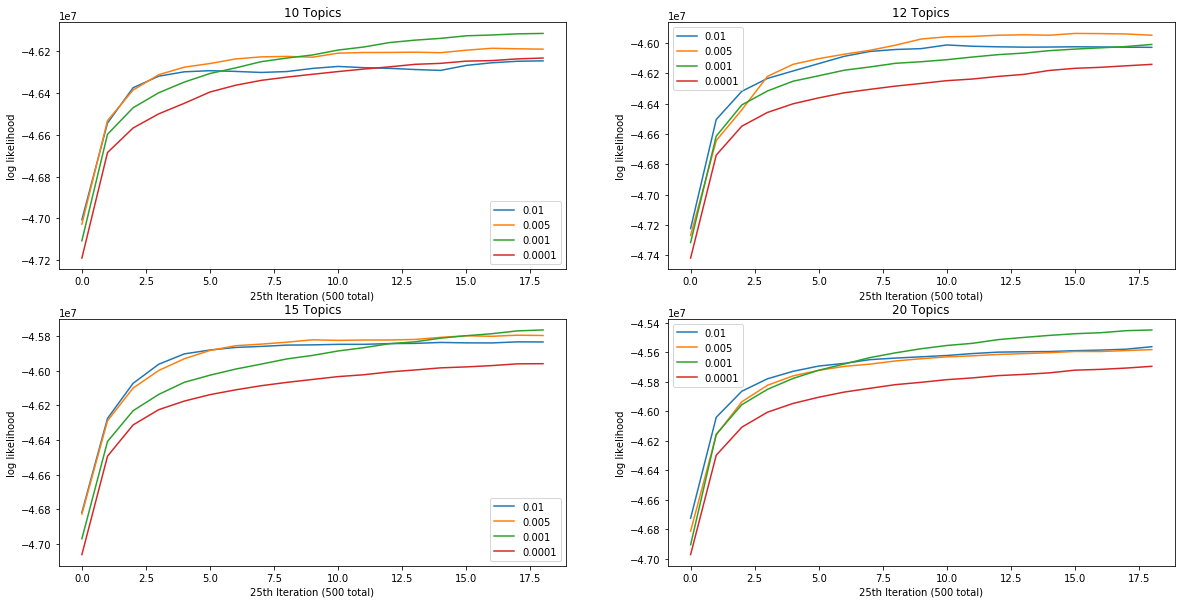

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(model_score[(10,0.01,0.1)], label='0.01')
plt.plot(model_score[(10,0.005,0.1)], label='0.005')
plt.plot(model_score[(10,0.001,0.1)], label='0.001')
plt.plot(model_score[(10,0.0001,0.1)], label='0.0001')
plt.legend()
plt.ylabel('log likelihood')
plt.xlabel('25th Iteration (500 total)')
plt.title('10 Topics')

plt.subplot(2,2,2)
plt.plot(model_score[(12,0.01,0.1)], label='0.01')
plt.plot(model_score[(12,0.005,0.1)], label='0.005')
plt.plot(model_score[(12,0.001,0.1)], label='0.001')
plt.plot(model_score[(12,0.0001,0.1)], label='0.0001')
plt.legend()
plt.ylabel('log likelihood')
plt.xlabel('25th Iteration (500 total)')
plt.title('12 Topics')


plt.subplot(2,2,3)
plt.plot(model_score[(15,0.01,0.1)], label='0.01')
plt.plot(model_score[(15,0.005,0.1)], label='0.005')
plt.plot(model_score[(15,0.001,0.1)], label='0.001')
plt.plot(model_score[(15,0.0001,0.1)], label='0.0001')
plt.legend()
plt.ylabel('log likelihood')
plt.xlabel('25th Iteration (500 total)')
plt.title('15 Topics')

plt.subplot(2,2,4)
plt.plot(model_score[(20,0.01,0.1)], label='0.01')
plt.plot(model_score[(20,0.005,0.1)], label='0.005')
plt.plot(model_score[(20,0.001,0.1)], label='0.001')
plt.plot(model_score[(20,0.0001,0.1)], label='0.0001')
plt.legend()
plt.ylabel('log likelihood')
plt.xlabel('25th Iteration (500 total)')
plt.title('20 Topics')

plt.show()

In [75]:
#try the fit method
t0 = time()
dev_vectorizer = CountVectorizer(vocabulary = tf_vocab)
dev_idx = list(all_idx.difference(train_idx))
dev_idx = dev_idx[:100000] #takes too long to go through all emails
dev_emails = emails_df.loc[dev_idx,]
dev_content = list(dev_emails['email_str'])
tf_dev = dev_vectorizer.fit_transform(dev_content)

#params for glda
alpha = 0.01
eta = 0.1
n_topics = 15
n_iters = 500

glda = guidedlda.GuidedLDA(n_topics = n_topics, n_iter = n_iters, random_state = 7, refresh = 25,\
                                       alpha = alpha, eta = eta)
glda.fit(tf_train, seed_topics = seed_topics, seed_confidence = seed_confidence)
doc_topic_distr = glda.transform(tf_dev)
print("finished in {}".format(time() - t0))


INFO:guidedlda:n_documents: 22206
INFO:guidedlda:vocab_size: 22830
INFO:guidedlda:n_words: 5675974
INFO:guidedlda:n_topics: 15
INFO:guidedlda:n_iter: 500
/home/cmiller11/anaconda3/lib/python3.6/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:guidedlda:<0> log likelihood: -64643056
INFO:guidedlda:<25> log likelihood: -46818411
INFO:guidedlda:<50> log likelihood: -46275292
INFO:guidedlda:<75> log likelihood: -46072104
INFO:guidedlda:<100> log likelihood: -45961940
INFO:guidedlda:<125> log likelihood: -45902051
INFO:guidedlda:<150> log likelihood: -45879747
INFO:guidedlda:<175> log likelihood: -45864758
INFO:guidedlda:<200> log likelihood: -45858828
INFO:guidedlda:<225> log likelihood: -45851325
INFO:guidedlda:<250> log likelihood: -45850017
INFO:guidedlda:<275> lo

finished in 314.01945304870605


In [76]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

tf_feature_names = dev_vectorizer.get_feature_names()
print_top_words(glda, tf_feature_names, 20)

Topic #0: ferc et order rto transmission meeting commission comments pm issues filing information sent know message original attached draft need request
Topic #1: 09 dgdgdgdgdg gas dgdgdgdgdgdg intercontinentalexchange data error 000 database pool dec date 01 com power index 0f hpl natural click
Topic #2: company said million stock financial new billion dow jones investors business shares energy credit trading news mr dynegy debt year
Topic #3: com agreement message sara swap sent pm doc corp original thanks attached mail shackleton isda intended credit know fax ena
Topic #4: power california state said energy electricity market prices utilities davis price ferc federal commission new companies utility generators public gas
Topic #5: 3d font td br nbsp size scientech com tr align width images gif face href arial updated right new span
Topic #6: market california iso ferc price power na energy order time electricity markets jeff cap prices ees dasovich generation costs wholesale
Topic #

In [100]:
print(doc_topic_distr[0])
print(np.argmax(doc_topic_distr[0]))
print(doc_topic_distr.shape)
for i, distr in enumerate(doc_topic_distr):
    if np.argmax(distr) == 3:
        print(emails_df.loc[dev_idx[i]]['email_str'])
        print("\n\n")
        

[2.20430333e-02 7.91052303e-04 8.15798857e-02 1.67582224e-04
 3.48927087e-02 6.09829383e-02 7.36740877e-02 2.21737929e-02
 3.35922494e-04 4.82517700e-01 1.42524203e-01 2.09821079e-04
 2.64479353e-04 4.38336178e-02 3.40091753e-02]
9
(100000, 15)
brenda please use the second check as my october payment <s> i have my copy of the original deal <s> do you want me to fax this to you ? <s> phillip <s>



nymex expiration is during this time frame <s> please reschedule <s>



by phillip k allen/hou/ect on DGDG/DGDG/DGDGDGDG DGDG:DGDG am - '' bs stone '' < bs_stone yahoo.com > on DGDG/DGDG/DGDGDGDG DGDG:DGDG:DGDG am to : `` jeff '' < jeff freeyellow.com > cc : `` phillip k allen '' < phillip.k.allen enron.com > subject : closing jeff ? <s> is the closing today ? ? <s> after reviewing the agreement ? i find it is n't binding as far as i can determine. ? <s> it is too vague and it does n't sound like anything an attorney or title company would ? draft for a real estate closing but of course i cou


jacques have you received the assignment letter from marcus kolb <s> this letter makes it sound like the assumption is just between the kuo 's and success real estate <s> do n't they need something signed from southern pacific bank ? <s> i certainly do n't plan on signing any assignment documents before the release is signed and settled <s> has their attorney contacted you with any revisions ? <s> is the ball in their court ? <s> phillip <s>



-original message - from : '' jeff smith '' < jsmith austintx.com < mailto : jsmith austintx.com > > enron [ mailto : imceanotes-+22jeff+20smith+22+20+3cjsmith+40austintx+2ecom+3e+40enron enron.com ] < mailto : [ mailto : imceanotes-+22jeff+20smith+22+20+3cjsmith+40austintx+2ecom+3e+40enron enron.com ] > sent : tuesday june DGDG DGDGDGDG DGDG:DGDG pm to : allen phillip k. subject : re : yes they do need to get approval from southern pacific bank <s> their attorney says that the bank has not responded to their requests <s> pauline is still tryin




rhonda you need to check with genia as i have never handled the physical power agreement matters <s> susan -original message - from : denton rhonda l. sent : tuesday january DGDG DGDGDGDG DG:DGDG pm to : bailey susan cc : hansen leslie subject : southern company netting here 's southern <s> i never received a copy of the virginia electric master netting <s> we do have netting within the eei <s> < < file : 96096123.pdf > > <s>



all attached is the demand letter log which represents those non-terminated counterparties who received a demand letter regarding the payment of monies due to ena for financial deals <s> cordially susan s. bailey enron north america corp. DGDGDGDG smith street suite 3803a houston texas DGDGDGDGDG phone : ( DGDGDG ) DGDGDG-DGDGDGDG fax : ( DGDGDG ) DGDGDG-DGDGDGDG email : susan.bailey enron.com <s>



sara here is my request as sent to tom moran and veronica gonzalez <s> i also this request to beth apollo so she could process it thru her channels <s> to date 

john i have attached a copy of the redraft of the one pager - let me know whether the format and content is consistent with your aspirations for it 's use ! ! <s> thanks mike ps - i am in new york at mg offices with brent for next DG-DG days whilst i will not have email - brent will <s>



inventory summaries for both mgl and mgmcc as of may DGDG DGDGDGDG have been posted in s\mg\capital mgl inventory.xls mgmcc inventory.xls <s>



attached are my accomplishments for the first half of DGDGDGDG. i will also ask my assistant to deliver a hard copy to you on wednesday july DG. let me know if you have any questions or need more information <s> thanks <s>



the following documents detailing mcc and mg ltd middle offices have been posted in s\mg\administration\meeting reports\ mcc london mobo description-28th june.doc mgl london mobo description-28th june.doc <s>



attached is may 's curve validation memorandum <s> we apologize for the late distribution this month <s> please call with any 

attached is a copy of the fort pierce press release included in the DG/DGDG edition of the fort pierce tribune <s> i have also included an updated version of the deal team list <s> let me know of any updates or changes <s> mathew <s>



the following file contains a graphical view of the north american gas average deal count by trader and product for eol <s> this information is for comparative analysis only <s> do not update links when opening this file <s> if you have any questions regarding this breakout please let me know <s> thanks matt motsinger enrononline x35221 <s>



attached is a revised credit watch listing for the week of DG/DGDG/DGDG <s> please note that the paralan company and sgl carbon llc were added to the credit watch list <s> also southstar energy services llc had been moved to `` no trades '' <s> if there are any personnel in your group that were not included in this distribution please insure that they receive a copy of this report <s> to add additional people to t

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.






this memo is to remind you of the qbr that is scheduled for tomorrow for the east mid market date : DG/DGDG/DGDG time : DG:DGDG - DGDG:DGDG am place : eb DGDGDGDG topic : east mid market please contact either kay ( 3x0643 ) or beverly ( 5x7857 ) if you have any questions <s>



just a reminder : the following qbr has been scheduled for your unit : date : DG/DGDG/DGDG time : DG pm - DG pm place : eb3314 topic : coal & emissions qbr please contact kay ( 3x0643 ) or beverly ( 5x7857 ) if you have any questions <s> thanks <s>



just a reminder the following qbr has been scheduled for your attendance : date : august DGDG DGDGDGDG time : DG:DGDG pm to DG:DGDG pm place : eb3314 topic : qbr if you have any questions please contact kay ( 3x0643 ) or beverly ( 5x7857 ) thanks <s>



this memo is to remind you of the qbr that will be held for your unit date : august DGDG DGDGDGDG time : DG:DGDG am to DGDG:DGDG pm place : eb DGDGDGDG please contact either kay ( 3x0643 ) or beverly ( 5x7857 ) 

mr. porter : per the request of cary carrabine attached please find an executable version of the master firm purchase/sale agreement between enovate l.l.c <s> and hess energy services l.l.c <s> also attached is a redlined version of the agreement which shows your changes that i have incorporated <s> if everything is satisfactory please print two copies of the executable agreement and secure signature on behalf of hess energy services <s> please fax a copy of the partially-executed agreement to cary and mail the originals to him <s> we will send you a fully-executed original for your files <s> should you have any questions feel free to contact me at ( DGDGDG ) DGDGDG-DGDGDGDG. stacy dickson <s>



cary attached are executable gisb and master firm agreements for conoco which incorporate conoco 's comments <s> stacy <s>



susan i left a message last week for brenda frankenhauser about the columbia assignment <s> she has not returned my call <s> stacy <s>



susan please use the new maste

daren and lauri per gary i am forwarding the below percentage split for spinnaker <s> i have highlighted the split in blue <s> thank you ! ! ! ! <s> christy DGDGDGDGDG by christy sweeney/hou/ect on DGDG/DGDG/DGDGDGDG DGDG:DGDG pm - dan mccue < mccue spinexp.com > on DGDG/DGDG/DGDGDGDG DGDG:DGDG:DGDG am to : `` 'christy.sweeney enron.com ' '' < christy.sweeney enron.com > cc : `` 'gbryan enron.com ' '' < gbryan enron.com > `` bill young ( e-mail ) '' < billyoung3 aol.com > subject : fw : n. padre DGDGDG gas allocation christy i think there is a good chance that the information shown below went to you or your office <s> i would like to get involved in finalizing plans for revenue distribution for the n. padre production <s> i am certain you are way ahead of me on this matter <s> spinnaker expects a division order title opining within a few weeks <s> i also expect the attorney to make some title requirements which will delay a final opinion <s> in talking with ranger and the houston explo

(100000, 15)
Counter({7: 29565, 13: 16644, 11: 13949, 0: 8967, 3: 8149, 6: 4703, 9: 3625, 4: 3201, 12: 3132, 1: 2085, 14: 1809, 10: 1477, 5: 1315, 2: 1068, 8: 311})


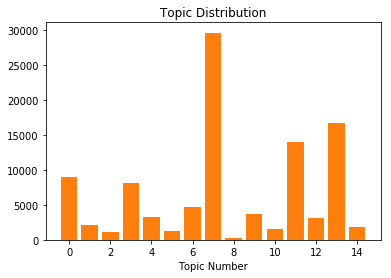

finished in 0.30979394912719727


In [98]:
t0 = time()
print(doc_topic_distr.shape)
top_topic = collections.Counter()
for i in range(doc_topic_distr.shape[0]):
    top_topic[np.argmax(doc_topic_distr[i])] += 1
print(top_topic)
plt.bar(top_topic.keys(), top_topic.values())
plt.title('Topic Distribution')
plt.xlabel('Topic Number')
plt.show()
print("finished in {}".format(time()-t0))